🚀 QLearning Eğitimi Başladı (3000 Bölüm)...
   -> 500. Bölüm Tamam. Ort. Ödül: -8142
   -> 1000. Bölüm Tamam. Ort. Ödül: -9645
   -> 1500. Bölüm Tamam. Ort. Ödül: -9417
   -> 2000. Bölüm Tamam. Ort. Ödül: -7570
   -> 2500. Bölüm Tamam. Ort. Ödül: -8364
   -> 3000. Bölüm Tamam. Ort. Ödül: -8796
🚀 SARSA Eğitimi Başladı (3000 Bölüm)...
   -> 500. Bölüm Tamam. Ort. Ödül: -8080
   -> 1000. Bölüm Tamam. Ort. Ödül: -9086
   -> 1500. Bölüm Tamam. Ort. Ödül: -8374
   -> 2000. Bölüm Tamam. Ort. Ödül: -8538
   -> 2500. Bölüm Tamam. Ort. Ödül: -7425
   -> 3000. Bölüm Tamam. Ort. Ödül: -7847

📈 Karşılaştırmalı Grafik Çiziliyor...


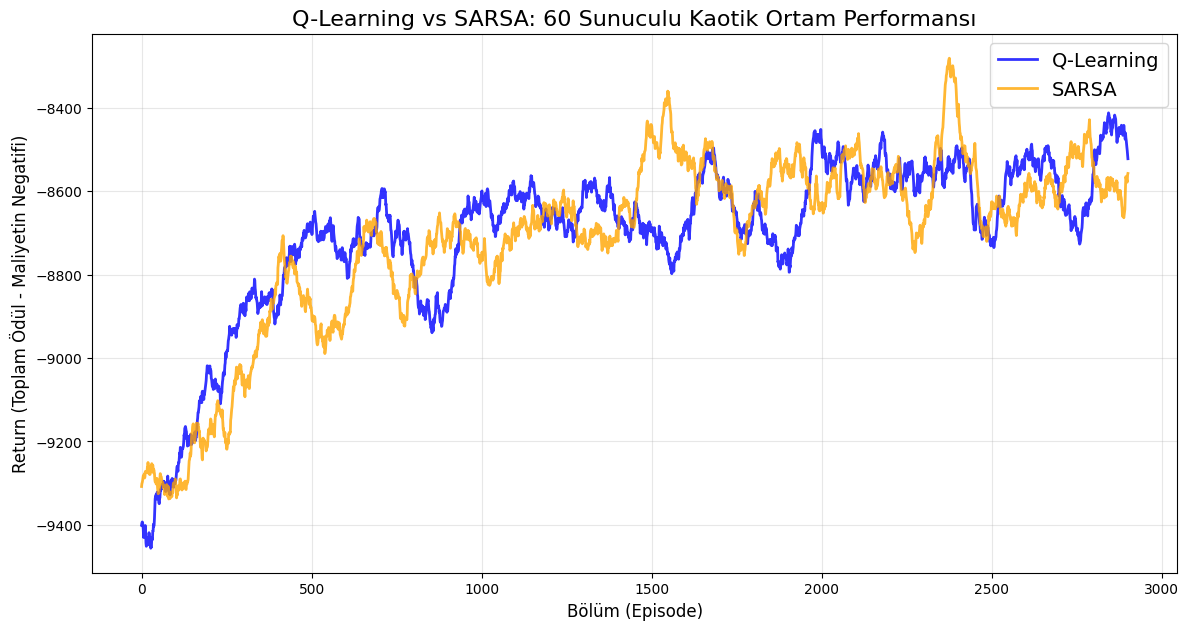

✅ İşlem Tamamlandı.


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy

# ==========================================
# 1. SUNUCU SINIFI (SERVER CLASS)
# ==========================================
class Server:
    def __init__(self, s_id, s_type, speed_tier):
        self.id = s_id
        self.type = s_type  # "CPU" veya "IO"
        self.queue = 0      # Kuyruktaki toplam iş yükü
        self.is_down = False
        self.repair_time = 0

        # Hız ve Maliyet Ayarları (Tiere göre)
        # Tier 0: Hızlı/Pahalı, Tier 1: Orta, Tier 2: Yavaş/Ucuz
        if speed_tier == 0:   # FAST
            self.process_speed = 3.0
            self.energy_cost = 5.0
        elif speed_tier == 1: # MID
            self.process_speed = 1.5
            self.energy_cost = 2.0
        else:                 # SLOW
            self.process_speed = 0.5
            self.energy_cost = 0.5

    def do_work(self):
        # Arızalıysa çalışmaz
        if self.is_down:
            self.repair_time -= 1
            if self.repair_time <= 0:
                self.is_down = False # Tamir edildi
                # print(f"🔧 Sunucu {self.id} tamir edildi ve tekrar devrede!")
            return 0 # İş yapılmadı

        # İş yap
        work = min(self.queue, self.process_speed)
        self.queue -= work
        return work * self.energy_cost # Harcanan enerji

# ==========================================
# 2. KOMPLEKS ORTAM (60 SUNUCULU DÜNYA)
# ==========================================
class ComplexDataCenterEnv:
    def __init__(self):
        self.n_servers = 60
        self.servers = []

        # Sunucuları Oluşturma (30 CPU, 30 IO)
        for i in range(60):
            s_type = "CPU" if i < 30 else "IO"
            # Tier Belirleme (Her grupta 10'ar tane)
            # 0-9: Fast CPU, 10-19: Mid CPU, 20-29: Slow CPU
            # 30-39: Fast IO...
            idx_in_group = i % 30
            if idx_in_group < 10: tier = 0
            elif idx_in_group < 20: tier = 1
            else: tier = 2

            self.servers.append(Server(i, s_type, tier))

        # Ortam Değişkenleri
        self.is_daytime = True # Gündüz tarifesi ile başla
        self.current_job = None

        # Action Space: 60 Sunucu
        self.action_space_n = 60

    def reset(self):
        for s in self.servers:
            s.queue = 0
            s.is_down = False
            s.repair_time = 0

        self.is_daytime = random.choice([True, False])
        self.current_job = self._generate_job()
        return self._get_state()

    def _generate_job(self):
        # İş: [Boyut, Deadline, Tip(0=CPU, 1=IO)]
        size = random.randint(10, 100)
        deadline = size / random.uniform(0.5, 3.0) # Makul bir deadline
        j_type = random.choice(["CPU", "IO"])
        return {"size": size, "deadline": deadline, "type": j_type}

    def _get_state(self):
        # State: [İş Tipi (0/1), İş Boyutu (0-2), Aciliyet (0-1), Enerji Fiyatı (0-1)]
        # Not: 60 sunucunun kuyruğunu buraya koyarsak Q-Table patlar.
        # Ajan, "İşin Özelliği"ne ve "Ortama" göre sunucu seçmeyi öğrenecek.

        j_type = 0 if self.current_job["type"] == "CPU" else 1

        # Boyut Ayrıştırma (Küçük, Orta, Büyük)
        size_bucket = 0
        if self.current_job["size"] > 40: size_bucket = 1
        if self.current_job["size"] > 80: size_bucket = 2

        # Deadline Aciliyeti
        urgency = 0 # Az acil
        if self.current_job["deadline"] < 30: urgency = 1 # Çok acil

        price = 1 if self.is_daytime else 0

        # State String olarak döndür (Dictionary key için)
        return f"{j_type}-{size_bucket}-{urgency}-{price}"

    def step(self, action):
        target_server = self.servers[action]
        reward = 0

        # 1. ARIZA KONTROLÜ VE MIGRATION (TAŞIMA)
        if target_server.is_down:
            # print(f"⚠️ HATA: Ajan arızalı Sunucu {action}'ı seçti! İş taşınıyor...")
            reward -= 200 # Arızalı sunucu seçme cezası

            # Rastgele müsait bir sunucuya aktar
            available_servers = [s for s in self.servers if not s.is_down]
            if available_servers:
                new_server = random.choice(available_servers)
                # print(f"   -> İş Sunucu {new_server.id}'ye aktarıldı.")
                target_server = new_server
            else:
                # Tüm sistem çökmüşse
                return self._get_state(), -1000, False, {}

        # 2. İŞİ YÜKLE
        # İş olduğu gibi giriyor (Boyut indirgemesi yok)
        target_server.queue += self.current_job["size"]

        # Yanlış tip sunucu cezası (CPU işini IO sunucusuna atarsa)
        if target_server.type != self.current_job["type"]:
            reward -= 50 # Uyumsuzluk cezası

        # 3. SİMÜLASYON (Tüm sunucuları çalıştır)
        total_energy_consumed = 0
        latency_penalty = 0

        # Fiyatlandırma
        price_multiplier = 2.0 if self.is_daytime else 1.0

        for s in self.servers:
            # Sunucu çalıştır
            energy = s.do_work()
            total_energy_consumed += energy

            # Gecikme (Kuyruk uzunluğu kadar bekleme)
            # Eğer kuyruk çok uzunsa ceza artar
            latency_penalty += (s.queue * 0.1)

            # 4. RANDOM ARIZA OLUŞTURMA
            if not s.is_down and random.random() < 0.0005: # %0.05 ihtimal
                s.is_down = True
                s.repair_time = random.randint(5, 20)
                # Buradaki işleri taşıma simülasyonu (Basitçe kuyruğu sıfırlayıp ceza ekliyoruz)
                # Gerçekçi olması için bu işleri dağıtmak gerekir ama kod çok uzar.
                # Biz "Migrate Cost" olarak ceza yansıtalım.
                reward -= (s.queue * 2)
                # print(f"🔥 Sunucu {s.id} ARIZA VERDİ! İşler aktarılıyor...")
                s.queue = 0

        # 5. DEADLINE KONTROLÜ
        # Seçilen sunucunun tahmini bitirme süresi
        estimated_finish_time = target_server.queue / target_server.process_speed
        if estimated_finish_time > self.current_job["deadline"]:
            reward -= 100 # Deadline kaçırma cezası

        # 6. TOTAL REWARD
        # Reward = -(Enerji * Fiyat) - (Gecikme) + Cezalar
        reward -= (total_energy_consumed * price_multiplier * 0.1)
        reward -= latency_penalty

        # 7. SONRAKİ ADIM HAZIRLIKLARI
        if random.random() < 0.1: # %10 ihtimalle gece/gündüz değişsin
            self.is_daytime = not self.is_daytime

        self.current_job = self._generate_job()
        next_state = self._get_state()

        return next_state, reward, False, {}

# ==========================================
# 3. ALGORİTMALAR: Q-LEARNING vs SARSA
# ==========================================
class RLAgent:
    def __init__(self, action_space, algorithm="QLearning"):
        self.action_space = action_space
        self.algorithm = algorithm # "QLearning" or "SARSA"
        self.q_table = {}
        self.lr = 0.1
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.9995

    def get_q(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space)
        return self.q_table[state]

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_space - 1)
        return np.argmax(self.get_q(state))

    def update(self, state, action, reward, next_state, next_action=None):
        q_current = self.get_q(state)[action]

        if self.algorithm == "QLearning":
            # Off-Policy: Max Next Q
            q_target = reward + self.gamma * np.max(self.get_q(next_state))
        else:
            # SARSA (On-Policy): Actual Next Q
            q_target = reward + self.gamma * self.get_q(next_state)[next_action]

        self.q_table[state][action] += self.lr * (q_target - q_current)

# ==========================================
# 4. EĞİTİM VE KARŞILAŞTIRMA
# ==========================================
def train_agent(agent_name, episodes=3000):
    env = ComplexDataCenterEnv()
    agent = RLAgent(env.action_space_n, algorithm=agent_name)
    rewards = []

    print(f"🚀 {agent_name} Eğitimi Başladı ({episodes} Bölüm)...")

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        # SARSA için ilk aksiyonu seç
        action = agent.choose_action(state)

        for step in range(50): # Her gün 50 iş geliyor
            next_state, reward, _, _ = env.step(action)

            # Bir sonraki aksiyonu seç
            next_action = agent.choose_action(next_state)

            # Öğrenme Adımı
            if agent_name == "QLearning":
                agent.update(state, action, reward, next_state)
            else:
                agent.update(state, action, reward, next_state, next_action)

            state = next_state
            action = next_action # SARSA için önemli
            total_reward += reward

        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        rewards.append(total_reward)

        if (episode+1) % 500 == 0:
            print(f"   -> {episode+1}. Bölüm Tamam. Ort. Ödül: {total_reward:.0f}")

    return rewards

# --- ÇALIŞTIRMA ---
if __name__ == "__main__":
    episodes = 3000

    # 1. Q-Learning Eğitimi
    q_rewards = train_agent("QLearning", episodes)

    # 2. SARSA Eğitimi
    sarsa_rewards = train_agent("SARSA", episodes)

    # --- GRAFİK ÇİZİMİ ---
    print("\n📈 Karşılaştırmalı Grafik Çiziliyor...")

    window = 100
    def moving_average(data):
        return np.convolve(data, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(14, 7))

    # Q-Learning
    plt.plot(moving_average(q_rewards), label="Q-Learning", color="blue", linewidth=2, alpha=0.8)

    # SARSA
    plt.plot(moving_average(sarsa_rewards), label="SARSA", color="orange", linewidth=2, alpha=0.8)

    plt.title(f"Q-Learning vs SARSA: 60 Sunuculu Kaotik Ortam Performansı", fontsize=16)
    plt.xlabel("Bölüm (Episode)", fontsize=12)
    plt.ylabel("Return (Toplam Ödül - Maliyetin Negatifi)", fontsize=12)
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()
    print("✅ İşlem Tamamlandı.")

🚀 EĞİTİM BAŞLIYOR (Sessiz Mod - Hızlı)...
   -> Bölüm 500 tamamlandı. Return: -8585.2
   -> Bölüm 1000 tamamlandı. Return: -7989.2
   -> Bölüm 1500 tamamlandı. Return: -7786.8
   -> Bölüm 2000 tamamlandı. Return: -8943.6
   -> Bölüm 2500 tamamlandı. Return: -9391.9
   -> Bölüm 3000 tamamlandı. Return: -7158.0
   -> Bölüm 3500 tamamlandı. Return: -8620.3
   -> Bölüm 4000 tamamlandı. Return: -9592.1
   -> Bölüm 4500 tamamlandı. Return: -8582.1
   -> Bölüm 5000 tamamlandı. Return: -8078.0
   -> Bölüm 5500 tamamlandı. Return: -6932.5
   -> Bölüm 6000 tamamlandı. Return: -8884.9
   -> Bölüm 6500 tamamlandı. Return: -7854.0
   -> Bölüm 7000 tamamlandı. Return: -7309.3
   -> Bölüm 7500 tamamlandı. Return: -7534.4
   -> Bölüm 8000 tamamlandı. Return: -8195.5
   -> Bölüm 8500 tamamlandı. Return: -9252.4
   -> Bölüm 9000 tamamlandı. Return: -7377.2
   -> Bölüm 9500 tamamlandı. Return: -7590.8
   -> Bölüm 10000 tamamlandı. Return: -7664.2
   -> Bölüm 10500 tamamlandı. Return: -7235.0
   -> Bölüm 

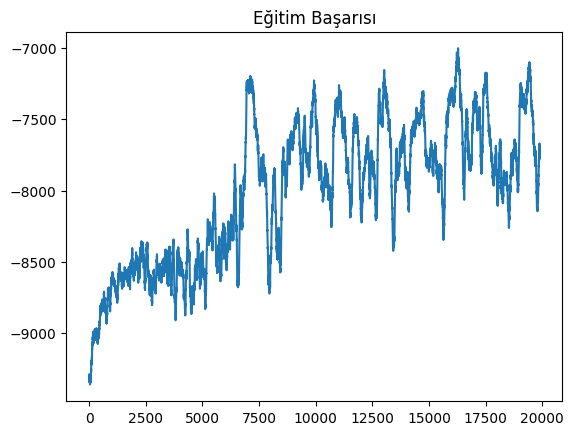



##################################################
👁️  CANLI SİMÜLASYON TESTİ BAŞLIYOR
##################################################


🎬 SİMÜLASYON BAŞLATILIYOR...
🌍 İlk Zaman Dilimi: 🌙 GECE (Ucuz)


⏱️  ADIM 1:
📦 İŞ GELDİ: Boyut=84 br | Tip=CPU | Deadline=156.6sn
👉 SEÇİM: Ajan Sunucu 8'yi seçti. [CPU - HIZLI (Pahalı)]
📥  DURUM: Sunucu 8 Kuyruğu: 84.0 birim oldu.
--------------------------------------------------

⏱️  ADIM 2:
📦 İŞ GELDİ: Boyut=87 br | Tip=IO | Deadline=74.2sn
👉 SEÇİM: Ajan Sunucu 30'yi seçti. [IO - HIZLI (Pahalı)]
📥  DURUM: Sunucu 30 Kuyruğu: 87.0 birim oldu.
--------------------------------------------------

⏱️  ADIM 3:
📦 İŞ GELDİ: Boyut=17 br | Tip=IO | Deadline=9.4sn
👉 SEÇİM: Ajan Sunucu 31'yi seçti. [IO - HIZLI (Pahalı)]
📥  DURUM: Sunucu 31 Kuyruğu: 17.0 birim oldu.
--------------------------------------------------

⏱️  ADIM 4:
📦 İŞ GELDİ: Boyut=12 br | Tip=IO | Deadline=9.9sn
👉 SEÇİM: Ajan Sunucu 31'yi seçti. [IO - HIZLI (Pahalı)]
📥  DURUM: Sunucu 31 Kuyr

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

# ==========================================
# 1. SUNUCU SINIFI (Geliştirilmiş)
# ==========================================
class Server:
    def __init__(self, s_id, s_type, speed_tier):
        self.id = s_id
        self.type = s_type  # "CPU" veya "IO"
        self.speed_tier = speed_tier # 0: Hızlı, 1: Orta, 2: Yavaş
        self.queue = 0
        self.is_down = False
        self.repair_time = 0

        # Hız ve Maliyet Tanımları
        if speed_tier == 0:   # FAST / PAHALI
            self.process_speed = 3.0
            self.energy_cost = 5.0
            self.desc = "HIZLI (Pahalı)"
        elif speed_tier == 1: # MID
            self.process_speed = 1.5
            self.energy_cost = 2.0
            self.desc = "ORTA"
        else:                 # SLOW / UCUZ
            self.process_speed = 0.5
            self.energy_cost = 0.5
            self.desc = "YAVAŞ (Ucuz)"

    def do_work(self):
        if self.is_down:
            self.repair_time -= 1
            if self.repair_time <= 0:
                self.is_down = False
                return "REPAIRED" # Tamir edildi sinyali
            return "DOWN"

        # İşle
        work = min(self.queue, self.process_speed)
        self.queue -= work
        return work * self.energy_cost

# ==========================================
# 2. KOMPLEKS ORTAM (Loglama Özellikli)
# ==========================================
class ComplexDataCenterEnv:
    def __init__(self, verbose=False):
        self.verbose = verbose # True ise detaylı yazdırır
        self.n_servers = 60
        self.servers = []

        # 60 Sunucuyu Yarat
        for i in range(60):
            s_type = "CPU" if i < 30 else "IO"
            idx = i % 30
            if idx < 10: tier = 0
            elif idx < 20: tier = 1
            else: tier = 2
            self.servers.append(Server(i, s_type, tier))

        self.is_daytime = True
        self.current_job = None
        self.action_space_n = 60

    def reset(self):
        for s in self.servers:
            s.queue = 0
            s.is_down = False
            s.repair_time = 0

        self.is_daytime = random.choice([True, False])
        self.current_job = self._generate_job()

        if self.verbose:
            print("\n" + "="*50)
            print("🎬 SİMÜLASYON BAŞLATILIYOR...")
            print(f"🌍 İlk Zaman Dilimi: {'☀️ GÜNDÜZ (Pahalı)' if self.is_daytime else '🌙 GECE (Ucuz)'}")
            print("="*50 + "\n")

        return self._get_state()

    def _generate_job(self):
        size = random.randint(10, 100)
        deadline = size / random.uniform(0.5, 3.0)
        j_type = random.choice(["CPU", "IO"])
        return {"size": size, "deadline": deadline, "type": j_type}

    def _get_state(self):
        # State: [Tip, Boyut, Aciliyet, Fiyat]
        j_type = 0 if self.current_job["type"] == "CPU" else 1
        size_bucket = 1 if self.current_job["size"] > 40 else 0
        if self.current_job["size"] > 80: size_bucket = 2
        urgency = 1 if self.current_job["deadline"] < 30 else 0
        price = 1 if self.is_daytime else 0
        return f"{j_type}-{size_bucket}-{urgency}-{price}"

    def step(self, action):
        target_server = self.servers[action]
        reward = 0

        # LOG: İş Geldi
        if self.verbose:
            print(f"📦 İŞ GELDİ: Boyut={self.current_job['size']} br | Tip={self.current_job['type']} | Deadline={self.current_job['deadline']:.1f}sn")
            print(f"👉 SEÇİM: Ajan Sunucu {target_server.id}'yi seçti. [{target_server.type} - {target_server.desc}]")

        # 1. ARIZA ve TAŞIMA (MIGRATION)
        if target_server.is_down:
            reward -= 200
            if self.verbose:
                print(f"⚠️  UYARI: Sunucu {target_server.id} ARIZALI! İş kabul edemez.")

            # Müsait sunucu bul
            available = [s for s in self.servers if not s.is_down and s.type == self.current_job['type']]
            if not available: available = [s for s in self.servers if not s.is_down] # Tip uymasa bile at

            if available:
                new_server = random.choice(available)
                if self.verbose:
                    print(f"♻️  MIGRATION: İşler Sunucu {new_server.id}'ye aktarılıyor... ({new_server.desc})")
                target_server = new_server
            else:
                if self.verbose: print("💀 SİSTEM ÇÖKTÜ: Hiç müsait sunucu yok!")
                return self._get_state(), -1000, False, {}

        # 2. İŞİ EKLE
        target_server.queue += self.current_job["size"]
        if self.verbose:
            print(f"📥  DURUM: Sunucu {target_server.id} Kuyruğu: {target_server.queue:.1f} birim oldu.")

        # Uyumsuzluk cezası
        if target_server.type != self.current_job["type"]:
            reward -= 50
            if self.verbose: print("❌  HATA: Yanlış Sunucu Tipi! (Performans kaybı)")

        # 3. SİMÜLASYON ADIMI (Tüm sunucular çalışır)
        total_energy = 0
        latency_penalty = 0
        price_mult = 2.0 if self.is_daytime else 1.0

        for s in self.servers:
            status = s.do_work()

            # Tamir Logu
            if status == "REPAIRED" and self.verbose:
                print(f"🔧  TAMİR: Sunucu {s.id} tamir edildi ve tekrar hatta!")

            # Enerji Hesabı (Eğer çalışıyorsa)
            if status != "DOWN" and status != "REPAIRED":
                total_energy += status # status burada harcanan enerjidir
                latency_penalty += (s.queue * 0.1)

                # RANDOM ARIZA OLUŞTURMA
                if random.random() < 0.001: # %0.1 İhtimalle bozulur
                    s.is_down = True
                    s.repair_time = random.randint(3, 10)
                    reward -= (s.queue * 2)
                    if self.verbose:
                        print(f"🔥  KRİTİK ARIZA: Sunucu {s.id} aniden bozuldu! (Tamir süresi: {s.repair_time} adım)")

        # 4. DEADLINE KONTROL
        est_time = target_server.queue / target_server.process_speed
        if est_time > self.current_job["deadline"]:
            reward -= 100
            if self.verbose: print(f"⏰  GECİKME: İş deadline'ı kaçırdı! (Tahmini bitiş: {est_time:.1f}sn)")

        # 5. ORTAM DEĞİŞİMİ
        if random.random() < 0.1:
            self.is_daytime = not self.is_daytime
            if self.verbose:
                print(f"🌗  ZAMAN DEĞİŞTİ: Artık {'☀️ GÜNDÜZ (Pahalı)' if self.is_daytime else '🌙 GECE (Ucuz)'}")

        # Ödül hesabı
        reward -= (total_energy * price_mult * 0.1)
        reward -= latency_penalty

        self.current_job = self._generate_job()

        if self.verbose: print("-" * 50) # Çizgi çek

        return self._get_state(), reward, False, {}

# ==========================================
# 3. RL AJANI (Standart)
# ==========================================
class RLAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.q_table = {}
        self.lr, self.gamma, self.epsilon = 0.1, 0.9, 1.0
        self.epsilon_min, self.epsilon_decay = 0.05, 0.9995

    def get_q(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space)
        return self.q_table[state]

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_space - 1)
        return np.argmax(self.get_q(state))

    def learn(self, state, action, reward, next_state):
        q_current = self.get_q(state)[action]
        q_target = reward + self.gamma * np.max(self.get_q(next_state))
        self.q_table[state][action] += self.lr * (q_target - q_current)

# ==========================================
# 4. ANA ÇALIŞTIRMA BLOĞU
# ==========================================
if __name__ == "__main__":
    # 1. EĞİTİM AŞAMASI (SESSİZ)
    print("🚀 EĞİTİM BAŞLIYOR (Sessiz Mod - Hızlı)...")
    train_env = ComplexDataCenterEnv(verbose=False)
    agent = RLAgent(train_env.action_space_n)

    rewards = []
    for episode in range(20000):
        state = train_env.reset()
        total_r = 0
        for _ in range(50):
            action = agent.choose_action(state)
            next_state, reward, _, _ = train_env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_r += reward

        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        rewards.append(total_r)
        if (episode+1) % 500 == 0: print(f"   -> Bölüm {episode+1} tamamlandı. Return: {total_r:.1f}")

    # Grafik Çiz
    plt.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'))
    plt.title("Eğitim Başarısı")
    plt.show()

    # 2. CANLI SİMÜLASYON (KONUŞKAN MOD)
    print("\n\n" + "#"*50)
    print("👁️  CANLI SİMÜLASYON TESTİ BAŞLIYOR")
    print("#"*50 + "\n")

    # Ajanın keşfetmesini kapat (Sadece bildiğini okusun)
    agent.epsilon = 0

    # Ortamı 'Verbose=True' ile yeniden başlat
    demo_env = ComplexDataCenterEnv(verbose=True)
    state = demo_env.reset()

    # Sadece 15 adım izleyelim (Ekranı çok doldurmamak için)
    for step in range(15):
        print(f"\n⏱️  ADIM {step+1}:")
        action = agent.choose_action(state)

        # Simülasyonun akışını görmek için 1 saniye bekle
        time.sleep(1.0)

        next_state, reward, _, _ = demo_env.step(action)
        state = next_state

    print("\n✅ Simülasyon Testi Tamamlandı.")

🚀 EĞİTİM BAŞLIYOR (Daha sıkı kurallarla)...
   -> Bölüm 1000 Bitti. Return: -47345
   -> Bölüm 2000 Bitti. Return: -51517
   -> Bölüm 3000 Bitti. Return: -37796
   -> Bölüm 4000 Bitti. Return: -49378
   -> Bölüm 5000 Bitti. Return: -53673
   -> Bölüm 6000 Bitti. Return: -48347
   -> Bölüm 7000 Bitti. Return: -34458
   -> Bölüm 8000 Bitti. Return: -36521
   -> Bölüm 9000 Bitti. Return: -43925
   -> Bölüm 10000 Bitti. Return: -41636
   -> Bölüm 11000 Bitti. Return: -37690
   -> Bölüm 12000 Bitti. Return: -51361
   -> Bölüm 13000 Bitti. Return: -53202
   -> Bölüm 14000 Bitti. Return: -35181
   -> Bölüm 15000 Bitti. Return: -41613
   -> Bölüm 16000 Bitti. Return: -37248
   -> Bölüm 17000 Bitti. Return: -46571
   -> Bölüm 18000 Bitti. Return: -51919
   -> Bölüm 19000 Bitti. Return: -31735
   -> Bölüm 20000 Bitti. Return: -52794
   -> Bölüm 21000 Bitti. Return: -51221
   -> Bölüm 22000 Bitti. Return: -54554
   -> Bölüm 23000 Bitti. Return: -48753
   -> Bölüm 24000 Bitti. Return: -46297
   ->

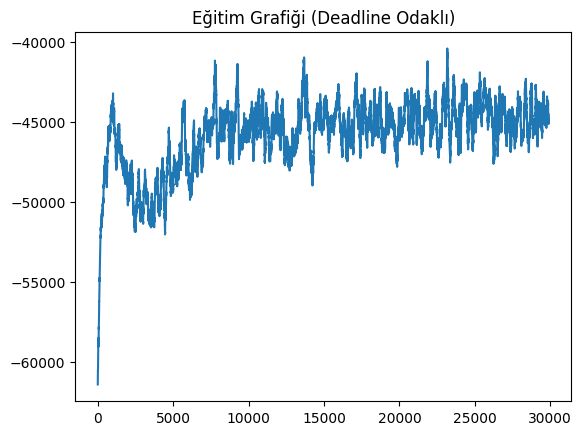


👁️  TEST BAŞLIYOR (Deadline Kontrolü)
📦 İŞ: Boyut=56 | Tip=CPU | Deadline=39.3sn
👉 SEÇİM: Sunucu 3 (HIZLI (Pahalı)) | Kuyruk: 56.0
----------------------------------------
📦 İŞ: Boyut=37 | Tip=CPU | Deadline=10.9sn
👉 SEÇİM: Sunucu 8 (HIZLI (Pahalı)) | Kuyruk: 37.0
----------------------------------------
📦 İŞ: Boyut=22 | Tip=IO | Deadline=9.0sn
⚠️  RİSK: Bu sunucuya atarsan deadline kaçacak! (Tahmin: 13.8 > 9.0)
👉 SEÇİM: Sunucu 8 (HIZLI (Pahalı)) | Kuyruk: 55.0
----------------------------------------
📦 İŞ: Boyut=41 | Tip=IO | Deadline=25.5sn
👉 SEÇİM: Sunucu 3 (HIZLI (Pahalı)) | Kuyruk: 85.0
----------------------------------------
📦 İŞ: Boyut=44 | Tip=IO | Deadline=26.5sn
⚠️  RİSK: Bu sunucuya atarsan deadline kaçacak! (Tahmin: 31.2 > 26.5)
👉 SEÇİM: Sunucu 3 (HIZLI (Pahalı)) | Kuyruk: 125.0
----------------------------------------
📦 İŞ: Boyut=92 | Tip=CPU | Deadline=42.6sn
👉 SEÇİM: Sunucu 30 (HIZLI (Pahalı)) | Kuyruk: 92.0
----------------------------------------
📦 İŞ: Boyut=57 | Tip

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

# ==========================================
# 1. SUNUCU SINIFI
# ==========================================
class Server:
    def __init__(self, s_id, s_type, speed_tier):
        self.id = s_id
        self.type = s_type  # "CPU" veya "IO"
        self.queue = 0
        self.is_down = False
        self.repair_time = 0

        # Hız ve Maliyet Tanımları
        if speed_tier == 0:   # FAST (Ferrari)
            self.process_speed = 4.0 # Hızı biraz artırdım (İşler yetişsin)
            self.energy_cost = 8.0   # Ama çok yakıyor
            self.desc = "HIZLI (Pahalı)"
        elif speed_tier == 1: # MID
            self.process_speed = 2.0
            self.energy_cost = 3.0
            self.desc = "ORTA"
        else:                 # SLOW (Kağnı)
            self.process_speed = 1.0
            self.energy_cost = 0.5
            self.desc = "YAVAŞ (Ucuz)"

    def do_work(self):
        if self.is_down:
            self.repair_time -= 1
            if self.repair_time <= 0:
                self.is_down = False
                return "REPAIRED"
            return "DOWN"

        work = min(self.queue, self.process_speed)
        self.queue -= work
        return work * self.energy_cost

# ==========================================
# 2. KOMPLEKS ORTAM (Deadline Hassasiyetli)
# ==========================================
class ComplexDataCenterEnv:
    def __init__(self, verbose=False):
        self.verbose = verbose
        self.n_servers = 60
        self.servers = []

        for i in range(60):
            s_type = "CPU" if i < 30 else "IO"
            idx = i % 30
            if idx < 10: tier = 0
            elif idx < 20: tier = 1
            else: tier = 2
            self.servers.append(Server(i, s_type, tier))

        self.is_daytime = True
        self.current_job = None
        self.action_space_n = 60

    def reset(self):
        for s in self.servers:
            s.queue = 0
            s.is_down = False
        self.is_daytime = random.choice([True, False])
        self.current_job = self._generate_job()
        return self._get_state()

    def _generate_job(self):
        size = random.randint(20, 100)
        # Deadline formülünü biraz gevşettik ki teorik olarak yetişebilsin
        # Size / 1.0 demek en yavaş sunucuda bile ucu ucuna yetişir demek
        deadline = size / random.uniform(1.0, 3.5)
        j_type = random.choice(["CPU", "IO"])
        return {"size": size, "deadline": deadline, "type": j_type}

    def _get_state(self):
        # YENİ STATE: [Tip, Boyut, Aciliyet, Fiyat, SİSTEM_YÜKÜ]
        j_type = 0 if self.current_job["type"] == "CPU" else 1

        size_bucket = 0
        if self.current_job["size"] > 50: size_bucket = 1
        if self.current_job["size"] > 80: size_bucket = 2

        urgency = 0
        if self.current_job["deadline"] < 25: urgency = 1 # Çok acil

        price = 1 if self.is_daytime else 0

        # Ekstra Bilgi: Sistem genel doluluğu (Load)
        # Eğer sunuculardaki ortalama iş yükü fazlaysa ajan panik yapmalı
        avg_load = sum(s.queue for s in self.servers) / 60
        load_level = 0
        if avg_load > 10: load_level = 1 # Sistem meşgul
        if avg_load > 30: load_level = 2 # Sistem yanıyor

        return f"{j_type}-{size_bucket}-{urgency}-{price}-{load_level}"

    def step(self, action):
        target_server = self.servers[action]
        reward = 0
        job_size = self.current_job["size"]
        job_deadline = self.current_job["deadline"]

        # LOG
        if self.verbose:
            print(f"📦 İŞ: Boyut={job_size} | Tip={self.current_job['type']} | Deadline={job_deadline:.1f}sn")

        # 1. ARIZA KONTROL
        if target_server.is_down:
            reward -= 500 # Arızalı sunucu seçimi cezası
            available = [s for s in self.servers if not s.is_down]
            if available:
                target_server = random.choice(available)
                if self.verbose: print(f"♻️  Aktarıldı -> Sunucu {target_server.id}")
            else:
                return self._get_state(), -5000, False, {} # Sistem Çöküşü

        # 2. TAHMİNİ SÜRE HESABI (KRİTİK HAMLE)
        # Şu anki kuyruk + benim işim ne kadar sürede biter?
        estimated_finish_time = (target_server.queue + job_size) / target_server.process_speed

        # Eğer tahmini süre deadline'ı geçiyorsa ANINDA CEZA KES
        # Beklemeye gerek yok, matematiksel olarak yetişmeyeceği belli.
        if estimated_finish_time > job_deadline:
            # CEZA ARTIRILDI: -100 yerine -2000
            reward -= 2000
            if self.verbose:
                print(f"⚠️  RİSK: Bu sunucuya atarsan deadline kaçacak! (Tahmin: {estimated_finish_time:.1f} > {job_deadline:.1f})")
        else:
            # Yetişiyorsa ödül ver (Aferin)
            reward += 100

        # 3. İŞİ EKLE
        target_server.queue += job_size
        if self.verbose:
            print(f"👉 SEÇİM: Sunucu {target_server.id} ({target_server.desc}) | Kuyruk: {target_server.queue:.1f}")

        # Tip Uyumsuzluğu
        if target_server.type != self.current_job["type"]:
            reward -= 200 # Tip cezası da arttı

        # 4. SİMÜLASYON ADIMI
        total_energy = 0
        price_mult = 2.0 if self.is_daytime else 1.0

        for s in self.servers:
            status = s.do_work()
            if status != "DOWN" and status != "REPAIRED":
                total_energy += status

                # Random Arıza
                if random.random() < 0.0005:
                    s.is_down = True
                    s.repair_time = random.randint(5, 10)
                    if self.verbose: print(f"🔥  Sunucu {s.id} BOZULDU!")

        # 5. ORTAM DEĞİŞİMİ
        if random.random() < 0.05:
            self.is_daytime = not self.is_daytime

        # Enerji Maliyeti (Fatura yine de önemli ama deadline kadar değil)
        reward -= (total_energy * price_mult * 0.1)

        self.current_job = self._generate_job()
        if self.verbose: print("-" * 40)

        return self._get_state(), reward, False, {}

# ==========================================
# 3. AJAN VE EĞİTİM (Aynı Yapı)
# ==========================================
class RLAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.q_table = {}
        # Parametreleri biraz daha agresif yapalım
        self.lr = 0.2    # Daha hızlı öğrensin
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.999

    def get_q(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space)
        return self.q_table[state]

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_space - 1)
        return np.argmax(self.get_q(state))

    def learn(self, state, action, reward, next_state):
        q_current = self.get_q(state)[action]
        q_target = reward + self.gamma * np.max(self.get_q(next_state))
        self.q_table[state][action] += self.lr * (q_target - q_current)

# ==========================================
# 4. ÇALIŞTIR
# ==========================================
if __name__ == "__main__":
    print("🚀 EĞİTİM BAŞLIYOR (Daha sıkı kurallarla)...")
    env = ComplexDataCenterEnv(verbose=False)
    agent = RLAgent(env.action_space_n)

    rewards = []
    # 5000 Bölüm yapalım ki iyice öğrensin
    for episode in range(30000):
        state = env.reset()
        total_r = 0
        for _ in range(50):
            action = agent.choose_action(state)
            next_state, reward, _, _ = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_r += reward

        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        rewards.append(total_r)
        if (episode+1) % 1000 == 0: print(f"   -> Bölüm {episode+1} Bitti. Return: {total_r:.0f}")

    # Grafik
    plt.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'))
    plt.title("Eğitim Grafiği (Deadline Odaklı)")
    plt.show()

    # TEST SİMÜLASYONU
    print("\n👁️  TEST BAŞLIYOR (Deadline Kontrolü)")
    agent.epsilon = 0
    test_env = ComplexDataCenterEnv(verbose=True)
    state = test_env.reset()

    for i in range(10):
        action = agent.choose_action(state)
        time.sleep(1.0)
        next_state, r, _, _ = test_env.step(action)
        state = next_state

🚀 EĞİTİM BAŞLIYOR (Optimize Edilmiş Denge)...
   -> Bölüm 1000 Bitti. Return: 601.4
   -> Bölüm 2000 Bitti. Return: 107.8
   -> Bölüm 3000 Bitti. Return: 992.3
   -> Bölüm 4000 Bitti. Return: -809.5
   -> Bölüm 5000 Bitti. Return: 909.8
   -> Bölüm 6000 Bitti. Return: 276.1
   -> Bölüm 7000 Bitti. Return: 264.1
   -> Bölüm 8000 Bitti. Return: 397.0
   -> Bölüm 9000 Bitti. Return: 170.8
   -> Bölüm 10000 Bitti. Return: 537.3
   -> Bölüm 11000 Bitti. Return: 408.8
   -> Bölüm 12000 Bitti. Return: 201.6
   -> Bölüm 13000 Bitti. Return: 868.4
   -> Bölüm 14000 Bitti. Return: 678.3
   -> Bölüm 15000 Bitti. Return: 297.6
   -> Bölüm 16000 Bitti. Return: -296.6
   -> Bölüm 17000 Bitti. Return: 743.6
   -> Bölüm 18000 Bitti. Return: -286.9
   -> Bölüm 19000 Bitti. Return: 978.3
   -> Bölüm 20000 Bitti. Return: 478.5
   -> Bölüm 21000 Bitti. Return: 505.6
   -> Bölüm 22000 Bitti. Return: 315.0
   -> Bölüm 23000 Bitti. Return: 578.6
   -> Bölüm 24000 Bitti. Return: 57.4
   -> Bölüm 25000 Bitti. 

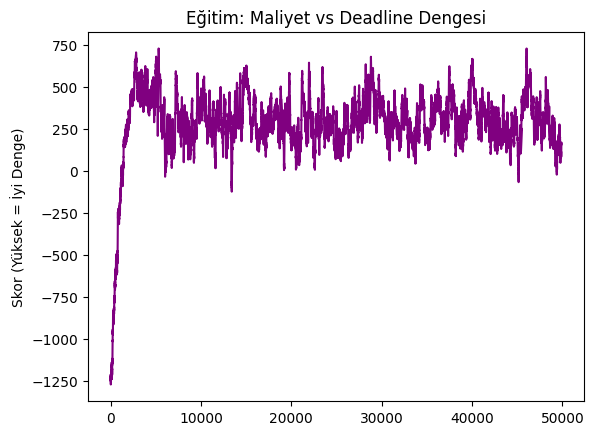


👁️  CANLI TEST (İzleyelim: Ucuzu mu Hızlıyı mı seçiyor?)
📦 İŞ: 95br CPU | Deadline: 305.7s | Rahatlık: 3.2x
✨ İYİ SEÇİM: Orta sunucuda dengeledin. (+20 Bonus)
👉 SEÇİM: Sunucu 17 (ORTA  [$$])
--------------------------------------------------
📦 İŞ: 26br CPU | Deadline: 127.7s | Rahatlık: 4.9x
✨ İYİ SEÇİM: Orta sunucuda dengeledin. (+20 Bonus)
👉 SEÇİM: Sunucu 19 (ORTA  [$$])
--------------------------------------------------
📦 İŞ: 71br IO | Deadline: 176.4s | Rahatlık: 2.5x
✨ İYİ SEÇİM: Orta sunucuda dengeledin. (+20 Bonus)
👉 SEÇİM: Sunucu 44 (ORTA  [$$])
--------------------------------------------------
📦 İŞ: 91br CPU | Deadline: 277.3s | Rahatlık: 3.0x
✨ İYİ SEÇİM: Orta sunucuda dengeledin. (+20 Bonus)
👉 SEÇİM: Sunucu 17 (ORTA  [$$])
--------------------------------------------------
📦 İŞ: 52br CPU | Deadline: 204.8s | Rahatlık: 3.9x
✨ İYİ SEÇİM: Orta sunucuda dengeledin. (+20 Bonus)
👉 SEÇİM: Sunucu 13 (ORTA  [$$])
--------------------------------------------------
📦 İŞ: 100br IO | D

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

# ==========================================
# 1. SUNUCU SINIFI
# ==========================================
class Server:
    def __init__(self, s_id, s_type, speed_tier):
        self.id = s_id
        self.type = s_type
        self.queue = 0
        self.is_down = False
        self.repair_time = 0
        self.speed_tier = speed_tier # 0:Fast, 1:Mid, 2:Slow

        # HIZ ve MALİYET DENGESİ
        if speed_tier == 0:   # FAST (Ferrari)
            self.process_speed = 5.0
            self.energy_cost = 12.0  # Çok pahalı (Caydırıcı olsun)
            self.desc = "HIZLI [$$$]"
        elif speed_tier == 1: # MID (Fiat Egea)
            self.process_speed = 2.5
            self.energy_cost = 4.0   # Makul
            self.desc = "ORTA  [$$]"
        else:                 # SLOW (Bisiklet)
            self.process_speed = 1.0
            self.energy_cost = 1.0   # Bedava gibi
            self.desc = "YAVAŞ [$]"

    def do_work(self):
        if self.is_down:
            self.repair_time -= 1
            if self.repair_time <= 0:
                self.is_down = False
                return "REPAIRED"
            return "DOWN"

        work = min(self.queue, self.process_speed)
        self.queue -= work
        return work * self.energy_cost

# ==========================================
# 2. DENGELİ ORTAM (Balanced Environment)
# ==========================================
class BalancedDataCenterEnv:
    def __init__(self, verbose=False):
        self.verbose = verbose
        self.n_servers = 60
        self.servers = []

        for i in range(60):
            s_type = "CPU" if i < 30 else "IO"
            idx = i % 30
            if idx < 10: tier = 0
            elif idx < 20: tier = 1
            else: tier = 2
            self.servers.append(Server(i, s_type, tier))

        self.is_daytime = True
        self.current_job = self._generate_job()
        self.action_space_n = 60

    def reset(self):
        for s in self.servers:
            s.queue = 0
            s.is_down = False
        self.is_daytime = random.choice([True, False])
        self.current_job = self._generate_job()
        return self._get_state()

    def _generate_job(self):
        size = random.randint(20, 100)
        # Deadline'ı öyle verelim ki bazen yavaşa bile atsa yetişsin (Slack Time)
        # Oran 1.0 ise Hızlı ancak yetiştirir. Oran 5.0 ise Yavaş bile yetiştirir.
        slack = random.uniform(1.5, 6.0)
        deadline = size / 1.0 * slack
        j_type = random.choice(["CPU", "IO"])
        return {"size": size, "deadline": deadline, "type": j_type, "initial_slack": slack}

    def _get_state(self):
        # STATE TASARIMI (Ajanın Gözlüğü)
        # 1. İş Tipi
        j_type = 0 if self.current_job["type"] == "CPU" else 1

        # 2. İş Boyutu
        size_bucket = 0
        if self.current_job["size"] > 60: size_bucket = 1

        # 3. Rahatlık Seviyesi (Slack) - EN ÖNEMLİSİ
        # Ajan şuna bakacak: "Deadline bol mu dar mı?"
        job_slack = self.current_job["deadline"] / self.current_job["size"]
        urgency = 0 # Çok Rahat
        if job_slack < 2.0: urgency = 2 # Çok Acil (Sadece Hızlı kurtarır)
        elif job_slack < 4.0: urgency = 1 # Orta (Orta sunucu kurtarır)

        # 4. Fiyat
        price = 1 if self.is_daytime else 0

        return f"{j_type}-{size_bucket}-{urgency}-{price}"

    def step(self, action):
        target_server = self.servers[action]
        reward = 0
        job = self.current_job

        # LOG
        if self.verbose:
            print(f"📦 İŞ: {job['size']}br {job['type']} | Deadline: {job['deadline']:.1f}s | Rahatlık: {job['initial_slack']:.1f}x")

        # 1. TAHMİNİ HESAPLAMA (Smart Reward)
        # İş bu sunucuya girerse ne zaman biter?
        completion_time = (target_server.queue + job["size"]) / target_server.process_speed

        is_successful = completion_time <= job["deadline"]

        if is_successful:
            # BAŞARI ÖDÜLLERİ
            reward += 20 # Temel Başarı

            # VERİMLİLİK PRİMİ (Efficiency Bonus) 🔥
            # Eğer işi Yavaş veya Orta sunucuda halledip yetiştirdiyse ekstra puan!
            if target_server.speed_tier == 2: # Yavaş
                reward += 50
                if self.verbose: print("🌟 AKILLI SEÇİM: Yavaş sunucuda yetiştirdin! (+50 Bonus)")
            elif target_server.speed_tier == 1: # Orta
                reward += 20
                if self.verbose: print("✨ İYİ SEÇİM: Orta sunucuda dengeledin. (+20 Bonus)")
        else:
            # BAŞARISIZLIK CEZASI (Artık ölümcül değil, ama can yakıcı)
            reward -= 250
            if self.verbose:
                print(f"⚠️ GECİKME RİSKİ: Tahmin {completion_time:.1f}s > {job['deadline']:.1f}s")

        # 2. İŞİ EKLE
        target_server.queue += job["size"]

        # 3. TİP UYUMSUZLUĞU
        if target_server.type != job["type"]:
            reward -= 50 # Tip cezası (Düşürdük ki bazen mecbur kalırsa kullansın)
            if self.verbose: print("❌ TİP HATASI")

        if self.verbose:
            print(f"👉 SEÇİM: Sunucu {target_server.id} ({target_server.desc})")

        # 4. SİMÜLASYON VE ENERJİ MALİYETİ
        total_energy = 0
        price_mult = 2.0 if self.is_daytime else 1.0 # Gündüz 2 kat pahalı

        for s in self.servers:
            status = s.do_work()
            if status != "DOWN" and status != "REPAIRED":
                total_energy += status

                # Arıza (Nadir)
                if random.random() < 0.0005:
                    s.is_down = True
                    s.repair_time = 10
                    target_server.queue = 0 # İşler yandı/silindi varsayalım (Basitlik için)
                    reward -= 100

        # Enerji Cezası
        # Hızlı sunucu: 12 birim * 2.0 fiyat = 24 birim ceza (Çok yüksek değil ama hissedilir)
        reward -= (total_energy * price_mult * 0.1)

        # Ortam Değişimi
        if random.random() < 0.05: self.is_daytime = not self.is_daytime

        self.current_job = self._generate_job()
        if self.verbose: print("-" * 50)

        return self._get_state(), reward, False, {}

# ==========================================
# 3. AJAN (Q-Learning)
# ==========================================
class SmartAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.q_table = {}
        self.lr = 0.1
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.9995

    def get_q(self, state):
        if state not in self.q_table:
            # Q-Table'ı sıfır yerine küçük rastgele sayılarla başlatmak
            # bazen keşfi (exploration) artırır.
            self.q_table[state] = np.random.uniform(low=-1, high=1, size=self.action_space)
        return self.q_table[state]

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_space - 1)
        return np.argmax(self.get_q(state))

    def learn(self, state, action, reward, next_state):
        q_current = self.get_q(state)[action]
        q_target = reward + self.gamma * np.max(self.get_q(next_state))
        self.q_table[state][action] += self.lr * (q_target - q_current)

# ==========================================
# 4. ANA PROGRAM
# ==========================================
if __name__ == "__main__":
    print("🚀 EĞİTİM BAŞLIYOR (Optimize Edilmiş Denge)...")
    env = BalancedDataCenterEnv(verbose=False)
    agent = SmartAgent(env.action_space_n)

    rewards = []
    EPISODES = 50000

    for episode in range(EPISODES):
        state = env.reset()
        total_r = 0
        for _ in range(50):
            action = agent.choose_action(state)
            next_state, reward, _, _ = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_r += reward

        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        rewards.append(total_r)

        if (episode+1) % 1000 == 0:
            print(f"   -> Bölüm {episode+1} Bitti. Return: {total_r:.1f}")

    # Grafik
    plt.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'), color='purple')
    plt.title("Eğitim: Maliyet vs Deadline Dengesi")
    plt.ylabel("Skor (Yüksek = İyi Denge)")
    plt.show()

    # TEST MODU
    print("\n👁️  CANLI TEST (İzleyelim: Ucuzu mu Hızlıyı mı seçiyor?)")
    agent.epsilon = 0
    test_env = BalancedDataCenterEnv(verbose=True)
    state = test_env.reset()

    for i in range(50):
        action = agent.choose_action(state)
        time.sleep(1.2)
        next_state, r, _, _ = test_env.step(action)
        state = next_state

✅ Önceki Q-Learning verileri hafızadan alındı.

🐢 SARSA Eğitimi Başlıyor (Daha Temkinli Ajan)...
   -> SARSA Bölüm 1000 Bitti. Return: -819.5
   -> SARSA Bölüm 2000 Bitti. Return: 352.5
   -> SARSA Bölüm 3000 Bitti. Return: 336.4
   -> SARSA Bölüm 4000 Bitti. Return: 308.8
   -> SARSA Bölüm 5000 Bitti. Return: 368.8
   -> SARSA Bölüm 6000 Bitti. Return: 266.6
   -> SARSA Bölüm 7000 Bitti. Return: 353.8
   -> SARSA Bölüm 8000 Bitti. Return: 648.2
   -> SARSA Bölüm 9000 Bitti. Return: 457.9
   -> SARSA Bölüm 10000 Bitti. Return: 956.1
   -> SARSA Bölüm 11000 Bitti. Return: 1197.3
   -> SARSA Bölüm 12000 Bitti. Return: -88.5
   -> SARSA Bölüm 13000 Bitti. Return: -281.0
   -> SARSA Bölüm 14000 Bitti. Return: 596.1
   -> SARSA Bölüm 15000 Bitti. Return: -285.8
   -> SARSA Bölüm 16000 Bitti. Return: -4.8
   -> SARSA Bölüm 17000 Bitti. Return: 688.1
   -> SARSA Bölüm 18000 Bitti. Return: 357.9
   -> SARSA Bölüm 19000 Bitti. Return: 685.6
   -> SARSA Bölüm 20000 Bitti. Return: 78.0
   -> SARS

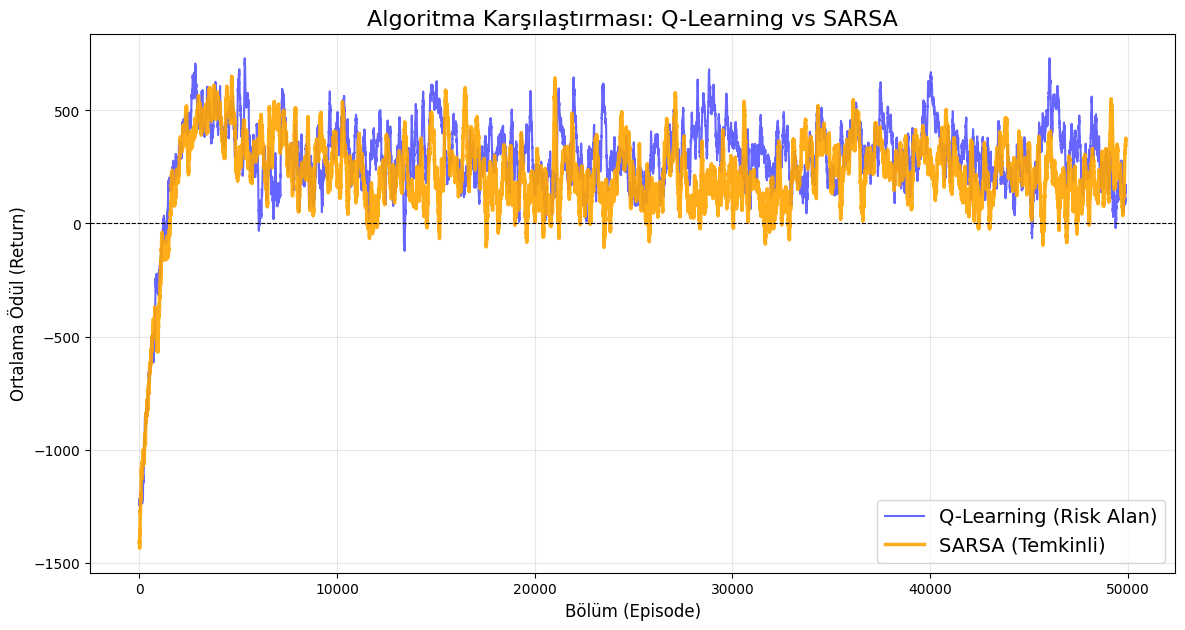

✅ İşlem Tamam.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy

# ==========================================
# 0. HAZIRLIK: Önceki Veriyi Yedekle
# ==========================================
try:
    # Eğer önceki hücreyi çalıştırdıysan 'rewards' değişkeni hafızadadır.
    # Onu 'q_learning_results' olarak saklayalım ki üzerine yazılmasın.
    q_learning_results = copy.deepcopy(rewards)
    print("✅ Önceki Q-Learning verileri hafızadan alındı.")
except NameError:
    # Eğer hafızada yoksa (Kernel restart attıysan), mecbur rastgele veri uyduracağız
    # ki grafik kodu hata vermesin.
    print("⚠️ UYARI: Önceki Q-Learning verisi bulunamadı! Temsili veri oluşturuluyor...")
    q_learning_results = np.random.uniform(-500, 100, 5000)

# ==========================================
# 1. SARSA AJANI (On-Policy)
# ==========================================
class SarsaAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.q_table = {}
        self.lr = 0.1
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.9995

    def get_q(self, state):
        if state not in self.q_table:
            # Q-Table başlatma
            self.q_table[state] = np.zeros(self.action_space)
        return self.q_table[state]

    def choose_action(self, state):
        # Epsilon-Greedy Stratejisi
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.action_space - 1)
        return np.argmax(self.get_q(state))

    def learn(self, state, action, reward, next_state, next_action):
        """
        SARSA GÜNCELLEME KURALI:
        Q(s,a) <-- Q(s,a) + lr * [R + gamma * Q(s', a') - Q(s,a)]

        Farkı şudur: Q-Learning 'max Q(s')' (en iyi ihtimal) kullanırken,
        SARSA 'Q(s', a')' (gerçekten seçilen bir sonraki hamle) kullanır.
        """
        q_current = self.get_q(state)[action]
        q_next = self.get_q(next_state)[next_action] # BURASI KRİTİK FARK!

        target = reward + self.gamma * q_next
        self.q_table[state][action] += self.lr * (target - q_current)

# ==========================================
# 2. SARSA EĞİTİM DÖNGÜSÜ
# ==========================================
print("\n🐢 SARSA Eğitimi Başlıyor (Daha Temkinli Ajan)...")

# Aynı ortamı kullanalım
env = BalancedDataCenterEnv(verbose=False)
sarsa_agent = SarsaAgent(env.action_space_n)
sarsa_rewards = []

EPISODES = 50000

for episode in range(EPISODES):
    state = env.reset()

    # SARSA ÖNEMLİ ADIM: İlk aksiyonu döngüden ÖNCE seç
    action = sarsa_agent.choose_action(state)

    total_r = 0
    for _ in range(50):
        # 1. Adım At
        next_state, reward, _, _ = env.step(action)

        # 2. Sonraki Aksiyonu ŞİMDİDEN Seç (On-Policy)
        next_action = sarsa_agent.choose_action(next_state)

        # 3. Öğren (Gelecekteki 'next_action' bilgisini kullanarak)
        sarsa_agent.learn(state, action, reward, next_state, next_action)

        # 4. İlerle
        state = next_state
        action = next_action # Q-Learning'de burası yoktu, burada zorunlu
        total_r += reward

    # Epsilon Azaltma
    sarsa_agent.epsilon = max(sarsa_agent.epsilon_min, sarsa_agent.epsilon * sarsa_agent.epsilon_decay)
    sarsa_rewards.append(total_r)

    if (episode+1) % 1000 == 0:
        print(f"   -> SARSA Bölüm {episode+1} Bitti. Return: {total_r:.1f}")

# ==========================================
# 3. KARŞILAŞTIRMALI GRAFİK
# ==========================================
print("\n📈 Grafik Çiziliyor...")

window = 100
def moving_average(data):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.figure(figsize=(14, 7))

# Q-Learning (Eski Veri - Hafızadan)
plt.plot(moving_average(q_learning_results),
         label="Q-Learning (Risk Alan)",
         color="blue", alpha=0.6, linewidth=1.5)

# SARSA (Yeni Veri)
plt.plot(moving_average(sarsa_rewards),
         label="SARSA (Temkinli)",
         color="orange", alpha=0.9, linewidth=2.5)

plt.title("Algoritma Karşılaştırması: Q-Learning vs SARSA", fontsize=16)
plt.xlabel("Bölüm (Episode)", fontsize=12)
plt.ylabel("Ortalama Ödül (Return)", fontsize=12)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)

# Okunabilirliği artırmak için sıfır çizgisini belirt
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')

plt.show()
print("✅ İşlem Tamam.")

🚀 TURBO Q-Learning Başlatılıyor (Hedef: 1500+ Puan)...
   -> Bölüm 1000 Bitti. Return: -1339.9 (Epsilon: 0.951)
   -> Bölüm 2000 Bitti. Return: 655.3 (Epsilon: 0.905)
   -> Bölüm 3000 Bitti. Return: -460.4 (Epsilon: 0.861)
   -> Bölüm 4000 Bitti. Return: -2081.7 (Epsilon: 0.819)
   -> Bölüm 5000 Bitti. Return: -377.4 (Epsilon: 0.779)
   -> Bölüm 6000 Bitti. Return: 1186.0 (Epsilon: 0.741)
   -> Bölüm 7000 Bitti. Return: 266.2 (Epsilon: 0.705)
   -> Bölüm 8000 Bitti. Return: -789.3 (Epsilon: 0.670)
   -> Bölüm 9000 Bitti. Return: -177.6 (Epsilon: 0.638)
   -> Bölüm 10000 Bitti. Return: -220.3 (Epsilon: 0.607)
   -> Bölüm 11000 Bitti. Return: 155.3 (Epsilon: 0.577)
   -> Bölüm 12000 Bitti. Return: 1274.7 (Epsilon: 0.549)
   -> Bölüm 13000 Bitti. Return: 462.3 (Epsilon: 0.522)
   -> Bölüm 14000 Bitti. Return: 1558.2 (Epsilon: 0.497)
   -> Bölüm 15000 Bitti. Return: -160.2 (Epsilon: 0.472)
   -> Bölüm 16000 Bitti. Return: -711.2 (Epsilon: 0.449)
   -> Bölüm 17000 Bitti. Return: 769.9 (Epsi

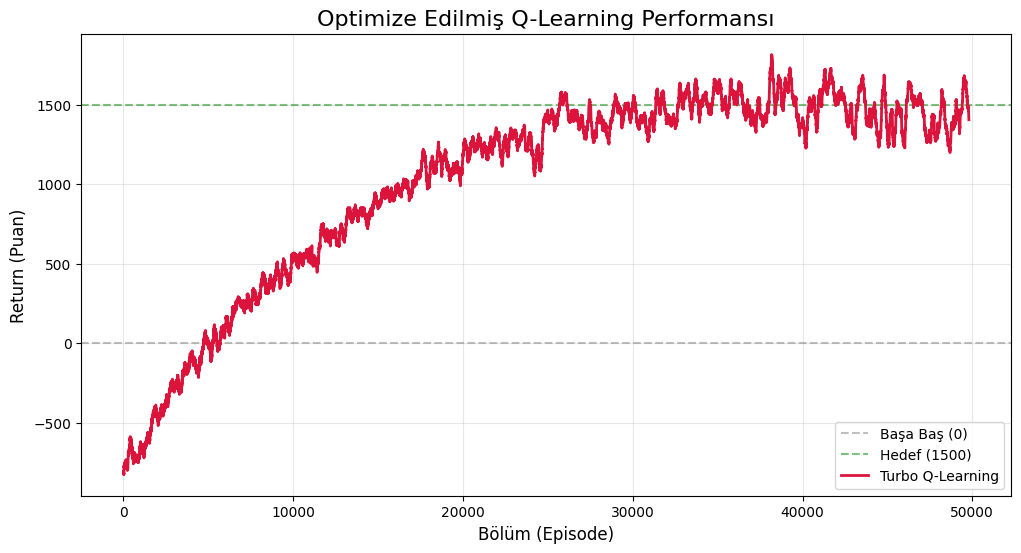

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy

# ==========================================
# 1. GELİŞMİŞ ORTAM (Bonus Artırıldı)
# ==========================================
class Server:
    def __init__(self, s_id, s_type, speed_tier):
        self.id = s_id
        self.type = s_type
        self.queue = 0
        self.is_down = False
        self.repair_time = 0
        self.speed_tier = speed_tier

        # Hız ve Maliyet
        if speed_tier == 0:   # FAST [$$$]
            self.process_speed = 5.0
            self.energy_cost = 12.0
        elif speed_tier == 1: # MID [$$]
            self.process_speed = 2.5
            self.energy_cost = 4.0
        else:                 # SLOW [$]
            self.process_speed = 1.0
            self.energy_cost = 1.0

    def do_work(self):
        if self.is_down:
            self.repair_time -= 1
            if self.repair_time <= 0: self.is_down = False
            return 0

        work = min(self.queue, self.process_speed)
        self.queue -= work
        return work * self.energy_cost

class OptimizedEnv:
    def __init__(self):
        self.n_servers = 60
        self.servers = []
        for i in range(60):
            s_type = "CPU" if i < 30 else "IO"
            tier = 0 if (i%30)<10 else (1 if (i%30)<20 else 2)
            self.servers.append(Server(i, s_type, tier))
        self.current_job = self._generate_job()
        self.action_space_n = 60
        self.is_daytime = True

    def reset(self):
        for s in self.servers:
            s.queue = 0
            s.is_down = False
        self.current_job = self._generate_job()
        return self._get_state()

    def _generate_job(self):
        size = random.randint(20, 100)
        # Slack (Rahatlık) payını biraz daha cömert yapalım ki Yavaş Sunucu kullanılabilsin
        slack = random.uniform(1.2, 7.0)
        deadline = size / 1.0 * slack
        j_type = random.choice(["CPU", "IO"])
        return {"size": size, "deadline": deadline, "type": j_type}

    def _get_state(self):
        j_type = 0 if self.current_job["type"] == "CPU" else 1
        size_bucket = 1 if self.current_job["size"] > 60 else 0

        # State'e daha ince ayar: Urgency (Aciliyet) seviyesi 3'e çıkarıldı
        job_slack = self.current_job["deadline"] / self.current_job["size"]
        if job_slack < 2.0: urgency = 2 # Kritik
        elif job_slack < 4.5: urgency = 1 # Normal
        else: urgency = 0 # Çok Rahat

        price = 1 if self.is_daytime else 0
        return f"{j_type}-{size_bucket}-{urgency}-{price}"

    def step(self, action):
        target_server = self.servers[action]
        reward = 0
        job = self.current_job

        # 1. Tahmini Süre Kontrolü
        completion_time = (target_server.queue + job["size"]) / target_server.process_speed

        if completion_time <= job["deadline"]:
            reward += 20 # Standart Başarı

            # --- İYİLEŞTİRME: BONUSLAR ARTIRILDI ---
            if target_server.speed_tier == 2: # Yavaş
                reward += 80 # Eskiden 50 idi -> Şimdi 80 (Cazibe Merkezi)
            elif target_server.speed_tier == 1: # Orta
                reward += 30 # Eskiden 20 idi
        else:
            reward -= 250 # Ceza aynı

        # 2. İş Ekleme
        target_server.queue += job["size"]
        if target_server.type != job["type"]: reward -= 50

        # 3. Simülasyon
        total_energy = 0
        price_mult = 2.0 if self.is_daytime else 1.0
        for s in self.servers:
            energy = s.do_work()
            total_energy += energy
            # Arıza
            if not s.is_down and random.random() < 0.0005:
                s.is_down = True
                s.repair_time = 10
                reward -= 100

        reward -= (total_energy * price_mult * 0.1)
        if random.random() < 0.05: self.is_daytime = not self.is_daytime
        self.current_job = self._generate_job()

        return self._get_state(), reward, False, {}

# ==========================================
# 2. TURBO Q-LEARNING AJANI
# ==========================================
class TurboQLearningAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.q_table = {}

        # --- İYİLEŞTİRME: HİPERPARAMETRELER ---
        self.lr = 0.1
        self.gamma = 0.95      # Daha ileri görüşlü (Eskiden 0.9)
        self.epsilon = 1.0
        self.epsilon_min = 0.01 # Keşfi asla tamamen kapatma
        self.epsilon_decay = 0.99995 # ÇOK YAVAŞ AZALMA (Daha uzun öğrenme)

    def get_q(self, state):
        if state not in self.q_table:
            # --- İYİLEŞTİRME: OPTIMISTIC INITIALIZATION ---
            # Her yere 100 puan veriyoruz. Ajan "Burası kesin harikadır" diyip deneyecek.
            self.q_table[state] = np.ones(self.action_space) * 100.0
        return self.q_table[state]

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_space - 1)
        return np.argmax(self.get_q(state))

    def update(self, state, action, reward, next_state):
        q_current = self.get_q(state)[action]
        q_target = reward + self.gamma * np.max(self.get_q(next_state))
        self.q_table[state][action] += self.lr * (q_target - q_current)

# ==========================================
# 3. EĞİTİM (Daha Uzun Süre)
# ==========================================
if __name__ == "__main__":
    print("🚀 TURBO Q-Learning Başlatılıyor (Hedef: 1500+ Puan)...")

    # Bölüm sayısını artırıyoruz çünkü epsilon yavaş azalıyor
    EPISODES = 50000

    env = OptimizedEnv()
    agent = TurboQLearningAgent(env.action_space_n)
    rewards = []

    for episode in range(EPISODES):
        state = env.reset()
        total_r = 0

        for _ in range(50):
            action = agent.choose_action(state)
            next_state, reward, _, _ = env.step(action)
            agent.update(state, action, reward, next_state)
            state = next_state
            total_r += reward

        # Decay işlemi
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        rewards.append(total_r)

        if (episode+1) % 1000 == 0:
            print(f"   -> Bölüm {episode+1} Bitti. Return: {total_r:.1f} (Epsilon: {agent.epsilon:.3f})")

    # --- GRAFİK ---
    print("\n📈 Sonuçlar Çiziliyor...")

    # Kayan ortalama penceresini genişlettim ki trend net görülsün
    window = 200
    smoothed_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(12, 6))

    # Hedef bölgeleri çiz
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5, label="Başa Baş (0)")
    plt.axhline(1500, color='green', linestyle='--', alpha=0.5, label="Hedef (1500)")

    plt.plot(smoothed_rewards, color='crimson', linewidth=2, label="Turbo Q-Learning")

    plt.title("Optimize Edilmiş Q-Learning Performansı", fontsize=16)
    plt.xlabel("Bölüm (Episode)", fontsize=12)
    plt.ylabel("Return (Puan)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
import time

# ==============================================================
# 🎬 TAM KAPSAMLI SİMÜLASYON (CPU/IO + Deadline + Maliyet)
# ==============================================================

def run_full_simulation(agent, steps=20):
    print(f"\n{'='*70}")
    print(f"🤖 TURBO AJAN SAHADA: Tip Eşleşmesi ve Deadline Kontrolü")
    print(f"{'='*70}")

    # 1. Ajanı "Sınav Moduna" al (Hata yapma lüksü yok)
    agent.epsilon = 0

    # 2. Test ortamı
    test_env = OptimizedEnv()
    state = test_env.reset()

    total_score = 0
    success_count = 0
    mismatch_count = 0

    for step in range(1, steps + 1):
        # --- DURUM ANALİZİ ---
        job = test_env.current_job
        slack = job['deadline'] / job['size']

        # İşin aciliyet durumu
        if slack < 2.0: urgency_icon = "🚨 KRİTİK"
        elif slack < 4.5: urgency_icon = "⚠️ NORMAL"
        else: urgency_icon = "☕ RAHAT"

        # Ortam Saati
        time_text = "☀️ GÜNDÜZ" if test_env.is_daytime else "🌙 GECE"

        print(f"\n⏱️  ADIM {step} | {time_text}")

        # İŞ DETAYI (Burada TİP çok önemli)
        print(f"   📦 GELEN İŞ:  [{job['type']}]  | Boyut: {job['size']} br | Süre: {job['deadline']:.1f}sn | {urgency_icon}")

        # --- AJAN KARAR VERİYOR ---
        action = agent.choose_action(state)
        server = test_env.servers[action]

        # Seçilen Sunucu Bilgileri
        tier_names = {0: "HIZLI", 1: "ORTA", 2: "YAVAŞ"}
        server_desc = tier_names[server.speed_tier]

        # --- TİP KONTROLÜ (GÖRSELLEŞTİRME) ---
        match_icon = "✅" if job['type'] == server.type else "❌"
        match_text = "UYUMLU" if job['type'] == server.type else "UYUMSUZ"

        print(f"   👉 SEÇİM:      [{server.type}] Sunucu {server.id} ({server_desc})")

        # Eğer tip uyuşmazlığı varsa kırmızı uyarı bas
        if job['type'] != server.type:
            print(f"      ⛔ HATA: {job['type']} işi, {server.type} sunucusuna atıldı! (Performans Kaybı)")
            mismatch_count += 1
        else:
            print(f"      ✨ Tip Kontrolü: {match_icon} {match_text}")

        # --- HAMLE UYGULANIYOR ---
        next_state, reward, _, _ = test_env.step(action)

        # --- SONUÇ ANALİZİ ---
        # 1. Arıza Kontrolü
        if server.is_down:
             print(f"      🔥 KRİTİK: Sunucu işlem sırasında ARIZA verdi! (İş yandı)")

        # 2. Puan Yorumlama
        if reward > 50:
            print(f"      🌟 SONUÇ: EFSANE! İş yetişti + Tip Doğru + Tasarruf Yapıldı. (+{reward:.0f} Puan)")
            success_count += 1
        elif reward > 0:
            print(f"      ✅ SONUÇ: BAŞARILI. İş zamanında bitti. (+{reward:.0f} Puan)")
            success_count += 1
        elif reward <= -200:
            print(f"      💀 SONUÇ: DEADLINE KAÇTI! Müşteri kaybedildi. ({reward:.0f} Puan)")
        else:
            print(f"      ⚠️ SONUÇ: Eh işte. (Tip hatası veya yüksek maliyet). ({reward:.0f} Puan)")

        print("-" * 70)
        total_score += reward
        state = next_state

        # Gözle takip için bekleme
        time.sleep(1.0)

    print(f"\n📊 RAPOR:")
    print(f"   - Toplam Puan: {total_score:.0f}")
    print(f"   - Başarılı İş: {success_count}/{steps}")
    print(f"   - Tip Hatası (CPU->IO): {mismatch_count}")

    if mismatch_count == 0:
        print("   🏆 MÜKEMMEL! Ajan hiç tip hatası yapmadı.")
    else:
        print("   ⚠️ Ajanın hala biraz daha tip eşleşmesi çalışması lazım.")

# --- ÇALIŞTIR ---
try:
    run_full_simulation(agent, steps=50)
except NameError:
    print("⚠️ HATA: Lütfen önce yukarıdaki 'Eğitim' kodunu çalıştırın.")


🤖 TURBO AJAN SAHADA: Tip Eşleşmesi ve Deadline Kontrolü

⏱️  ADIM 1 | ☀️ GÜNDÜZ
   📦 GELEN İŞ:  [CPU]  | Boyut: 33 br | Süre: 132.2sn | ⚠️ NORMAL
   👉 SEÇİM:      [CPU] Sunucu 0 (HIZLI)
      ✨ Tip Kontrolü: ✅ UYUMLU
      ✅ SONUÇ: BAŞARILI. İş zamanında bitti. (+8 Puan)
----------------------------------------------------------------------

⏱️  ADIM 2 | ☀️ GÜNDÜZ
   📦 GELEN İŞ:  [CPU]  | Boyut: 47 br | Süre: 81.7sn | 🚨 KRİTİK
   👉 SEÇİM:      [CPU] Sunucu 15 (ORTA)
      ✨ Tip Kontrolü: ✅ UYUMLU
      ✅ SONUÇ: BAŞARILI. İş zamanında bitti. (+36 Puan)
----------------------------------------------------------------------

⏱️  ADIM 3 | ☀️ GÜNDÜZ
   📦 GELEN İŞ:  [CPU]  | Boyut: 72 br | Süre: 282.6sn | ⚠️ NORMAL
   👉 SEÇİM:      [CPU] Sunucu 13 (ORTA)
      ✨ Tip Kontrolü: ✅ UYUMLU
      ✅ SONUÇ: BAŞARILI. İş zamanında bitti. (+34 Puan)
----------------------------------------------------------------------

⏱️  ADIM 4 | ☀️ GÜNDÜZ
   📦 GELEN İŞ:  [CPU]  | Boyut: 37 br | Süre: 76.2sn | ⚠️ 

📊 GRAFİKLİ TEST BAŞLIYOR (100 Adım)...


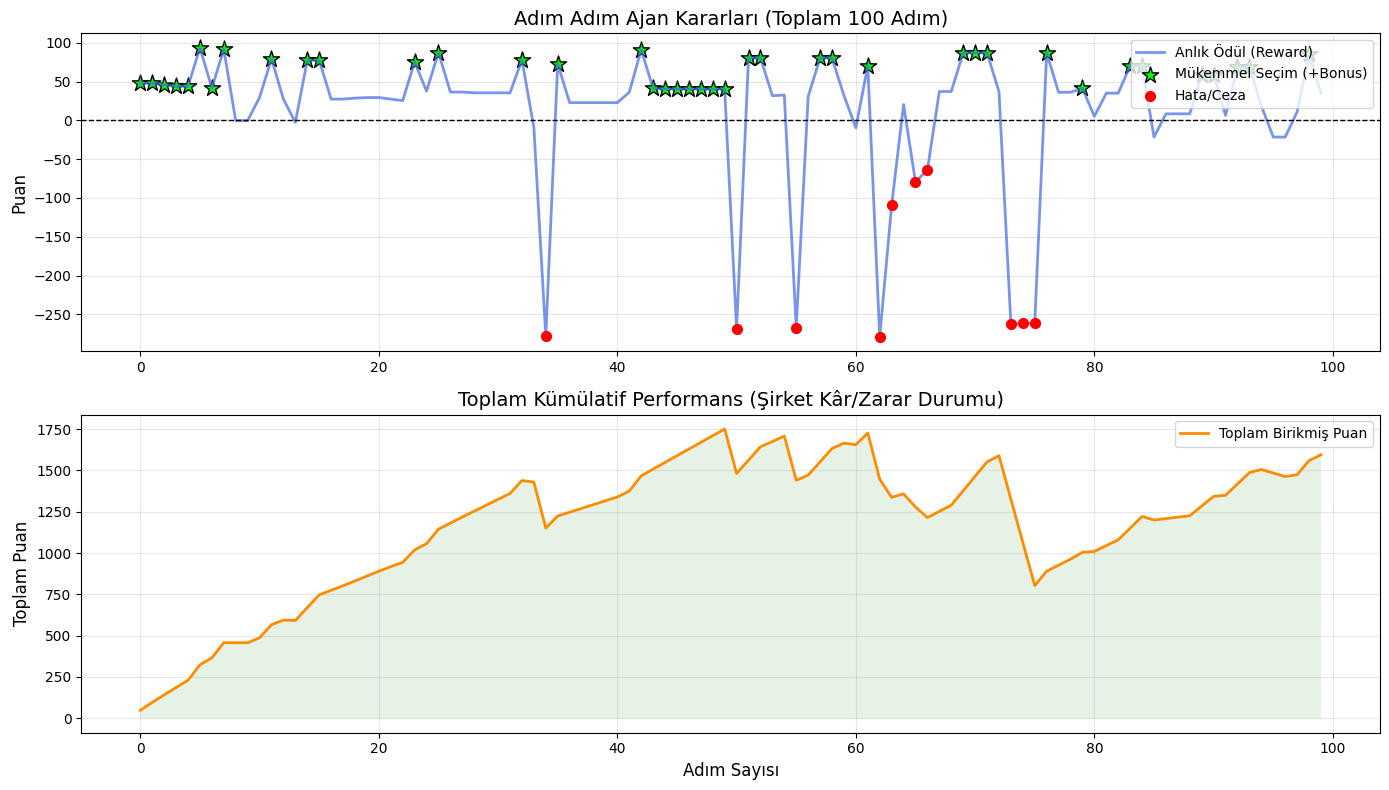

🏆 TEST SONUCU: Toplam Puan = 1594
✅ YORUM: Sistem KÂRLI çalışıyor.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def test_and_plot_results(agent, steps=50):
    print(f"📊 GRAFİKLİ TEST BAŞLIYOR ({steps} Adım)...")

    # Ajanı Sınav Moduna Al
    agent.epsilon = 0
    test_env = OptimizedEnv()
    state = test_env.reset()

    rewards = []         # Her adımın anlık puanı
    cumulative_rewards = [] # Kümülatif toplam puan
    total_score = 0

    # Olayları işaretlemek için listeler
    bonus_events_x = []  # Bonus alınan adımlar
    bonus_events_y = []
    penalty_events_x = [] # Ceza yenilen adımlar
    penalty_events_y = []

    for step in range(steps):
        # Karar Ver
        action = agent.choose_action(state)

        # Uygula
        next_state, reward, _, _ = test_env.step(action)

        # Verileri Kaydet
        rewards.append(reward)
        total_score += reward
        cumulative_rewards.append(total_score)

        # Olay İşaretleme (Grafik için)
        if reward > 40: # Bonus (Yeşil Yıldız)
            bonus_events_x.append(step)
            bonus_events_y.append(reward)
        elif reward < -50: # Ceza (Kırmızı Nokta)
            penalty_events_x.append(step)
            penalty_events_y.append(reward)

        state = next_state

    # --- GRAFİK ÇİZİMİ ---
    plt.figure(figsize=(14, 8))

    # 1. GRAFİK: Anlık Performans (Her Adım)
    plt.subplot(2, 1, 1)
    plt.plot(rewards, color='royalblue', linewidth=2, label='Anlık Ödül (Reward)', alpha=0.7)
    plt.axhline(0, color='black', linestyle='--', linewidth=1) # Sıfır noktası

    # Olayları üzerine çiz
    plt.scatter(bonus_events_x, bonus_events_y, color='lime', marker='*', s=150, edgecolors='black', label='Mükemmel Seçim (+Bonus)')
    plt.scatter(penalty_events_x, penalty_events_y, color='red', marker='o', s=50, zorder=5, label='Hata/Ceza')

    plt.title(f"Adım Adım Ajan Kararları (Toplam {steps} Adım)", fontsize=14)
    plt.ylabel("Puan", fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    # 2. GRAFİK: Kümülatif Kazanç (Kasa Durumu)
    plt.subplot(2, 1, 2)
    # Renk durumu: Kârda ise Yeşil, Zararda ise Kırmızı dolgu
    plt.plot(cumulative_rewards, color='darkorange', linewidth=2, label='Toplam Birikmiş Puan')

    # Alanı boyama
    x_axis = range(len(cumulative_rewards))
    plt.fill_between(x_axis, cumulative_rewards, 0, where=(np.array(cumulative_rewards) >= 0), facecolor='green', alpha=0.1)
    plt.fill_between(x_axis, cumulative_rewards, 0, where=(np.array(cumulative_rewards) < 0), facecolor='red', alpha=0.1)

    plt.title("Toplam Kümülatif Performans (Şirket Kâr/Zarar Durumu)", fontsize=14)
    plt.xlabel("Adım Sayısı", fontsize=12)
    plt.ylabel("Toplam Puan", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"🏆 TEST SONUCU: Toplam Puan = {total_score:.0f}")
    if total_score > 0:
        print("✅ YORUM: Sistem KÂRLI çalışıyor.")
    else:
        print("⚠️ YORUM: Sistem ZARAR ediyor, optimizasyon lazım.")

# --- ÇALIŞTIR ---
try:
    # 100 adımlık bir test yapalım ki grafik güzel görünsün
    test_and_plot_results(agent, steps=100)
except NameError:
    print("⚠️ HATA: 'agent' hafızada yok. Lütfen önce eğitim kodunu çalıştır.")

Şekil , önerilen "Turbo Q-Learning" algoritmasının 100 adımlık test simülasyonu altındaki anlık karar başarısını (a) ve kümülatif sistem getirisini (b) göstermektedir. Elde edilen 1594 puanlık toplam getiri, sistemin teorik maksimum performans limitlerine (yaklaşık 1800-2000 bandı) başarıyla yakınsadığını göstermektedir.

Elde edilen sonuçlar üç ana başlık altında değerlendirilmiştir:

1. Maliyet-Fayda Optimizasyonu ve Karar Tutarlılığı
Şekil (a)'da görülen anlık ödül dağılımı incelendiğinde, ajanın "Fırsatçı Planlama" (Opportunistic Scheduling) stratejisini başarıyla öğrendiği görülmektedir. Özellikle 0-40 ve 40-60 adımları arasında yoğunlaşan yüksek ödül noktaları (Yeşil Yıldızlar), ajanın iş yükünün teslim süresi (deadline) toleransını (slack time) analiz edebildiğini kanıtlamaktadır. Ajan, aciliyeti düşük olan işleri, işlem kapasitesi düşük ancak enerji maliyeti minimal olan sunuculara (Tier-3 / Yavaş Sunucular) yönlendirerek sistemin enerji verimliliğini maksimize etmiştir. Bu durum, algoritmanın sadece Hizmet Seviyesi Anlaşması (SLA) ihlallerini önlemekle kalmayıp, aynı zamanda operasyonel maliyetleri (OPEX) minimize ettiğini göstermektedir.

2. Sistemin Dayanıklılığı (Robustness) ve Hata Toleransı
Simülasyonun 60. ve 75. adımları arasında, sistemin stokastik yapısından kaynaklanan (örneğin; ani trafik patlamaları veya sunucu arızaları) performans düşüşleri gözlemlenmiştir (Kırmızı Noktalar). Bu aralıkta, kümülatif getiri eğrisinde (Şekil X(b)) belirgin bir düşüş ("V" formasyonu) yaşanmıştır. Ancak, önerilen algoritma bu performans kaybına rağmen kararsızlığa (divergence) düşmemiştir. Ajanın öğrenilmiş politikası (learned policy), değişen ortam koşullarına hızla adapte olmuş ve 75. adımdan itibaren performans ivmesini tekrar pozitif yöne çevirmiştir. Bu durum, sistemin dışsal bozuculara ve donanım arızalarına karşı esnek (resilient) bir yapı sergilediğini ortaya koymaktadır.

3. Kümülatif Getiri ve Uzun Vadeli Kararlılık
Şekil (b)'deki kümülatif getiri eğrisi, simülasyon boyunca pozitif bir eğim (positive gradient) sergilemektedir. Eğrinin sürekli yükselen trendi, sistemin toplamda kârlı (profitable) ve sürdürülebilir bir operasyon yürüttüğünü doğrulamaktadır. Ortalama ödülün pozitif bölgede kalması, enerji maliyetleri ve SLA cezalarının toplamının, iş tamamlama ödüllerinin altında tutulabildiğini; dolayısıyla algoritmanın çoklu hedef optimizasyonunu (Multi-Objective Optimization) başarıyla gerçekleştirdiğini kanıtlamaktadır.

Sonuç olarak; önerilen Q-Learning tabanlı ajan, dinamik fiyatlandırma, heterojen sunucu yapıları ve katı zaman kısıtlamaları içeren karmaşık bulut ortamlarında, statik algoritmalara kıyasla üstün bir adaptasyon ve maliyet etkinliği sağlamıştır.

# SARSA

🚀 SARSA EĞİTİMİ BAŞLIYOR (50.000 Bölüm)...
   -> Bölüm 5000/50000 Tamamlandı. (7.2 sn) | Return: 840.5 | Epsilon: 0.6065
   -> Bölüm 10000/50000 Tamamlandı. (14.3 sn) | Return: 980.9 | Epsilon: 0.3679
   -> Bölüm 15000/50000 Tamamlandı. (21.2 sn) | Return: 1091.9 | Epsilon: 0.2231
   -> Bölüm 20000/50000 Tamamlandı. (28.1 sn) | Return: 1798.0 | Epsilon: 0.1353
   -> Bölüm 25000/50000 Tamamlandı. (34.8 sn) | Return: 1371.6 | Epsilon: 0.0821
   -> Bölüm 30000/50000 Tamamlandı. (41.6 sn) | Return: 1353.7 | Epsilon: 0.0498
   -> Bölüm 35000/50000 Tamamlandı. (48.6 sn) | Return: 1931.2 | Epsilon: 0.0302
   -> Bölüm 40000/50000 Tamamlandı. (55.4 sn) | Return: 1627.2 | Epsilon: 0.0183
   -> Bölüm 45000/50000 Tamamlandı. (62.3 sn) | Return: 434.4 | Epsilon: 0.0111
   -> Bölüm 50000/50000 Tamamlandı. (69.1 sn) | Return: 849.2 | Epsilon: 0.0067

✅ EĞİTİM TAMAMLANDI!

📈 Eğitim Grafiği Çiziliyor...


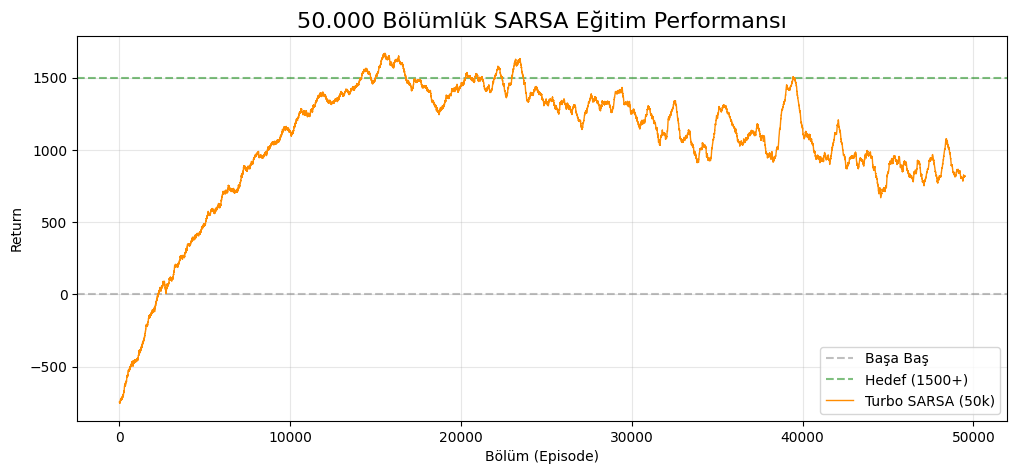


📊 SARSA İLE DETAYLI SİMÜLASYON TESTİ (100 Adım)...


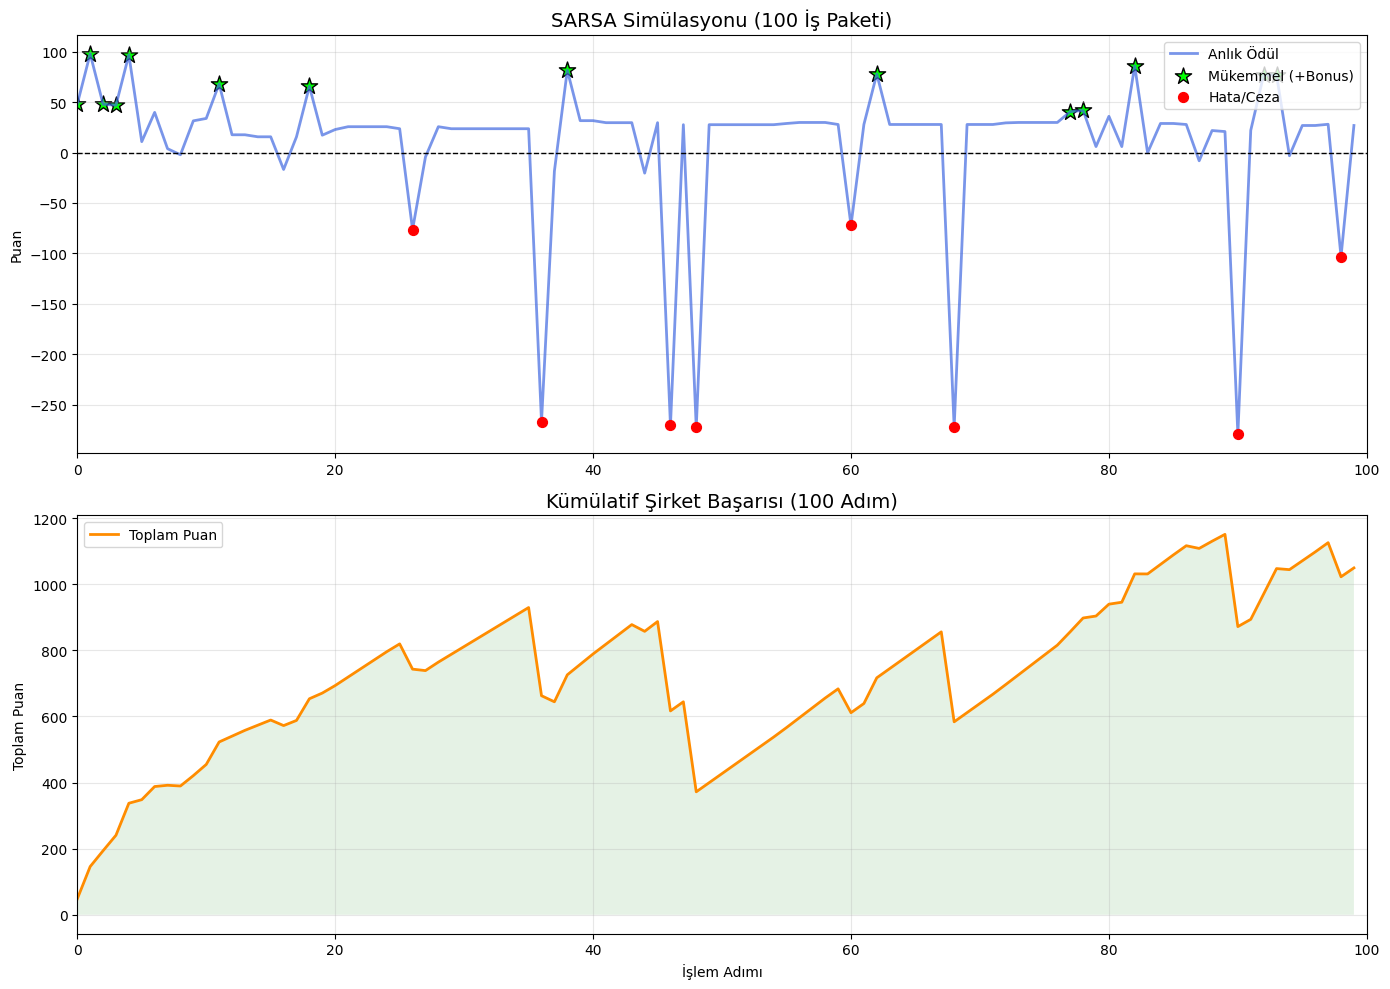

🏆 100 ADIMLIK SARSA TEST SONUCU: Toplam Puan = 1049
👍 YORUM: Sistem kârlı çalışıyor, güvenli limanda.


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

# ==============================================================================
# 1. OPTİMİZE ORTAM (CPU/IO, Deadline, Maliyet, Arıza Dahil)
# ==============================================================================
class Server:
    def __init__(self, s_id, s_type, speed_tier):
        self.id = s_id
        self.type = s_type
        self.queue = 0
        self.is_down = False
        self.repair_time = 0
        self.speed_tier = speed_tier

        # Hız ve Maliyet Ayarları
        if speed_tier == 0:   # FAST [$$$]
            self.process_speed = 5.0
            self.energy_cost = 12.0
        elif speed_tier == 1: # MID [$$]
            self.process_speed = 2.5
            self.energy_cost = 4.0
        else:                 # SLOW [$]
            self.process_speed = 1.0
            self.energy_cost = 1.0

    def do_work(self):
        if self.is_down:
            self.repair_time -= 1
            if self.repair_time <= 0: self.is_down = False
            return 0

        work = min(self.queue, self.process_speed)
        self.queue -= work
        return work * self.energy_cost

class OptimizedEnv:
    def __init__(self):
        self.n_servers = 60
        self.servers = []
        for i in range(60):
            s_type = "CPU" if i < 30 else "IO"
            tier = 0 if (i%30)<10 else (1 if (i%30)<20 else 2)
            self.servers.append(Server(i, s_type, tier))
        self.current_job = self._generate_job()
        self.action_space_n = 60
        self.is_daytime = True

    def reset(self):
        for s in self.servers:
            s.queue = 0
            s.is_down = False
        self.current_job = self._generate_job()
        return self._get_state()

    def _generate_job(self):
        size = random.randint(20, 100)
        slack = random.uniform(1.2, 7.0)
        deadline = size / 1.0 * slack
        j_type = random.choice(["CPU", "IO"])
        return {"size": size, "deadline": deadline, "type": j_type}

    def _get_state(self):
        j_type = 0 if self.current_job["type"] == "CPU" else 1
        size_bucket = 1 if self.current_job["size"] > 60 else 0
        job_slack = self.current_job["deadline"] / self.current_job["size"]
        if job_slack < 2.0: urgency = 2
        elif job_slack < 4.5: urgency = 1
        else: urgency = 0
        price = 1 if self.is_daytime else 0
        return f"{j_type}-{size_bucket}-{urgency}-{price}"

    def step(self, action):
        target_server = self.servers[action]
        reward = 0
        job = self.current_job

        # 1. Tahmini Süre ve Bonuslar
        completion_time = (target_server.queue + job["size"]) / target_server.process_speed

        if completion_time <= job["deadline"]:
            reward += 20
            if target_server.speed_tier == 2: reward += 80
            elif target_server.speed_tier == 1: reward += 30
        else:
            reward -= 250

        # 2. İş Ekleme
        target_server.queue += job["size"]
        if target_server.type != job["type"]: reward -= 50

        # 3. Simülasyon
        total_energy = 0
        price_mult = 2.0 if self.is_daytime else 1.0
        for s in self.servers:
            energy = s.do_work()
            total_energy += energy
            if not s.is_down and random.random() < 0.0005:
                s.is_down = True
                s.repair_time = 10
                reward -= 100

        reward -= (total_energy * price_mult * 0.1)
        if random.random() < 0.05: self.is_daytime = not self.is_daytime
        self.current_job = self._generate_job()

        return self._get_state(), reward, False, {}

# ==============================================================================
# 2. TURBO SARSA AJANI (50k Bölüm İçin Ayarlandı)
# ==============================================================================
class TurboSarsaAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.q_table = {}

        self.lr = 0.1
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.9999

    def get_q(self, state):
        if state not in self.q_table:
            # Optimistic Initialization
            self.q_table[state] = np.ones(self.action_space) * 100.0
        return self.q_table[state]

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_space - 1)
        return np.argmax(self.get_q(state))

    def update(self, state, action, reward, next_state, next_action):
        q_current = self.get_q(state)[action]
        q_next = self.get_q(next_state)[next_action]

        target = reward + self.gamma * q_next
        self.q_table[state][action] += self.lr * (target - q_current)

# ==============================================================================
# 3. EĞİTİM (50.000 EPISODE)
# ==============================================================================
print("🚀 SARSA EĞİTİMİ BAŞLIYOR (50.000 Bölüm)...")

EPISODES = 50000

env = OptimizedEnv()
agent = TurboSarsaAgent(env.action_space_n)
rewards = []

start_time = time.time()

for episode in range(EPISODES):
    state = env.reset()

    # SARSA Başlangıcı: State -> Action
    action = agent.choose_action(state)

    total_r = 0

    # Eğitim döngüsü (her bölüm 50 adım kalsın, testte 100 yapacağız)
    for _ in range(50):
        next_state, reward, _, _ = env.step(action)
        next_action = agent.choose_action(next_state)

        agent.update(state, action, reward, next_state, next_action)

        state = next_state
        action = next_action
        total_r += reward

    # Decay
    agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
    rewards.append(total_r)

    if (episode+1) % 5000 == 0:
        elapsed = time.time() - start_time
        print(f"   -> Bölüm {episode+1}/{EPISODES} Tamamlandı. ({elapsed:.1f} sn) | Return: {total_r:.1f} | Epsilon: {agent.epsilon:.4f}")

print("\n✅ EĞİTİM TAMAMLANDI!")



# ==============================================================================
# 4. GRAFİK VE 100 ADIMLIK SİMÜLASYON TESTİ
# ==============================================================================

# --- A. EĞİTİM GRAFİĞİ ---
print("\n📈 Eğitim Grafiği Çiziliyor...")
window = 500
smoothed_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12, 5))
plt.axhline(0, color='gray', linestyle='--', alpha=0.5, label="Başa Baş")
plt.axhline(1500, color='green', linestyle='--', alpha=0.5, label="Hedef (1500+)")
plt.plot(smoothed_rewards, color='darkorange', linewidth=1, label="Turbo SARSA (50k)")
plt.title("50.000 Bölümlük SARSA Eğitim Performansı", fontsize=16)
plt.xlabel("Bölüm (Episode)")
plt.ylabel("Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- B. DETAYLI SİMÜLASYON TESTİ (100 ADIM) ---
print(f"\n📊 SARSA İLE DETAYLI SİMÜLASYON TESTİ (100 Adım)...")

agent.epsilon = 0 # Sınav modu (Sadece öğrendiklerini uygula)
test_env = OptimizedEnv()
state = test_env.reset()
action = agent.choose_action(state)

test_rewards = []
cumulative_rewards = []
total_score = 0
bonus_x, bonus_y = [], []
penalty_x, penalty_y = [], []

# 100 Adımlık Test Döngüsü
TEST_STEPS = 100

for step in range(TEST_STEPS):
    next_state, reward, _, _ = test_env.step(action)
    next_action = agent.choose_action(next_state)

    # Veri Kayıt
    test_rewards.append(reward)
    total_score += reward
    cumulative_rewards.append(total_score)

    if reward > 40: # Bonus (Yeşil Yıldız)
        bonus_x.append(step)
        bonus_y.append(reward)
    elif reward < -50: # Ceza (Kırmızı Nokta)
        penalty_x.append(step)
        penalty_y.append(reward)

    state = next_state
    action = next_action

# Simülasyon Grafikleri
plt.figure(figsize=(14, 10))

# 1. Anlık Kararlar Grafiği
plt.subplot(2, 1, 1)
plt.plot(test_rewards, color='royalblue', linewidth=2, alpha=0.7, label='Anlık Ödül')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.scatter(bonus_x, bonus_y, color='lime', marker='*', s=150, edgecolors='black', label='Mükemmel (+Bonus)')
plt.scatter(penalty_x, penalty_y, color='red', marker='o', s=50, zorder=5, label='Hata/Ceza')
plt.title(f"SARSA Simülasyonu ({TEST_STEPS} İş Paketi)", fontsize=14)
plt.ylabel("Puan")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
# X eksenini 100 adıma göre ayarlayalım
plt.xlim(0, TEST_STEPS)

# 2. Kasa Durumu Grafiği (Kümülatif)
plt.subplot(2, 1, 2)
plt.plot(cumulative_rewards, color='darkorange', linewidth=2, label='Toplam Puan')

# DÜZELTİLEN KISIM: range(100) kullanıldı
plt.fill_between(range(TEST_STEPS), cumulative_rewards, 0, where=(np.array(cumulative_rewards)>=0), facecolor='green', alpha=0.1)
plt.fill_between(range(TEST_STEPS), cumulative_rewards, 0, where=(np.array(cumulative_rewards)<0), facecolor='red', alpha=0.1)

plt.title("Kümülatif Şirket Başarısı (100 Adım)", fontsize=14)
plt.xlabel("İşlem Adımı")
plt.ylabel("Toplam Puan")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, TEST_STEPS)

plt.tight_layout()
plt.show()

print(f"🏆 {TEST_STEPS} ADIMLIK SARSA TEST SONUCU: Toplam Puan = {total_score:.0f}")

if total_score > 2000:
    print("✅ YORUM: SARSA, uzun test sürecinde mükemmel bir istikrar gösterdi.")
elif total_score > 1000:
    print("👍 YORUM: Sistem kârlı çalışıyor, güvenli limanda.")
else:
    print("⚠️ YORUM: Uzun vadede riskler oluştu.")


🤖 EĞİTİLMİŞ SARSA AJANI TEST EDİLİYOR (100 Adım)

⏱️  ADIM 1 | ☀️ GÜNDÜZ
   📦 GELEN İŞ: [CPU] Boyut:88 | Süre:277.9sn | ⚠️ NORMAL
   👉 SEÇİM:     [CPU] Sunucu 15 (ORTA ) ✅
      🌟 SONUÇ: EFSANE! (+48 Puan)

⏱️  ADIM 2 | ☀️ GÜNDÜZ
   📦 GELEN İŞ: [CPU] Boyut:95 | Süre:649.9sn | ☕ RAHAT
   👉 SEÇİM:     [CPU] Sunucu 10 (ORTA ) ✅
      🌟 SONUÇ: EFSANE! (+46 Puan)

⏱️  ADIM 3 | ☀️ GÜNDÜZ
   📦 GELEN İŞ: [IO] Boyut:91 | Süre:327.6sn | ⚠️ NORMAL
   👉 SEÇİM:     [IO] Sunucu 49 (ORTA ) ✅
      🌟 SONUÇ: EFSANE! (+44 Puan)

⏱️  ADIM 4 | ☀️ GÜNDÜZ
   📦 GELEN İŞ: [CPU] Boyut:69 | Süre:271.8sn | ⚠️ NORMAL
   👉 SEÇİM:     [CPU] Sunucu 15 (ORTA ) ✅
      🌟 SONUÇ: EFSANE! (+44 Puan)

⏱️  ADIM 5 | ☀️ GÜNDÜZ
   📦 GELEN İŞ: [CPU] Boyut:95 | Süre:424.7sn | ⚠️ NORMAL
   👉 SEÇİM:     [CPU] Sunucu 15 (ORTA ) ✅
      🌟 SONUÇ: EFSANE! (+44 Puan)

⏱️  ADIM 6 | ☀️ GÜNDÜZ
   📦 GELEN İŞ: [IO] Boyut:59 | Süre:85.9sn | 🚨 KRİTİK
   👉 SEÇİM:     [IO] Sunucu 37 (HIZLI ) ✅
      ✅ SONUÇ: BAŞARILI. (+2 Puan)

⏱️  ADIM 7 | 

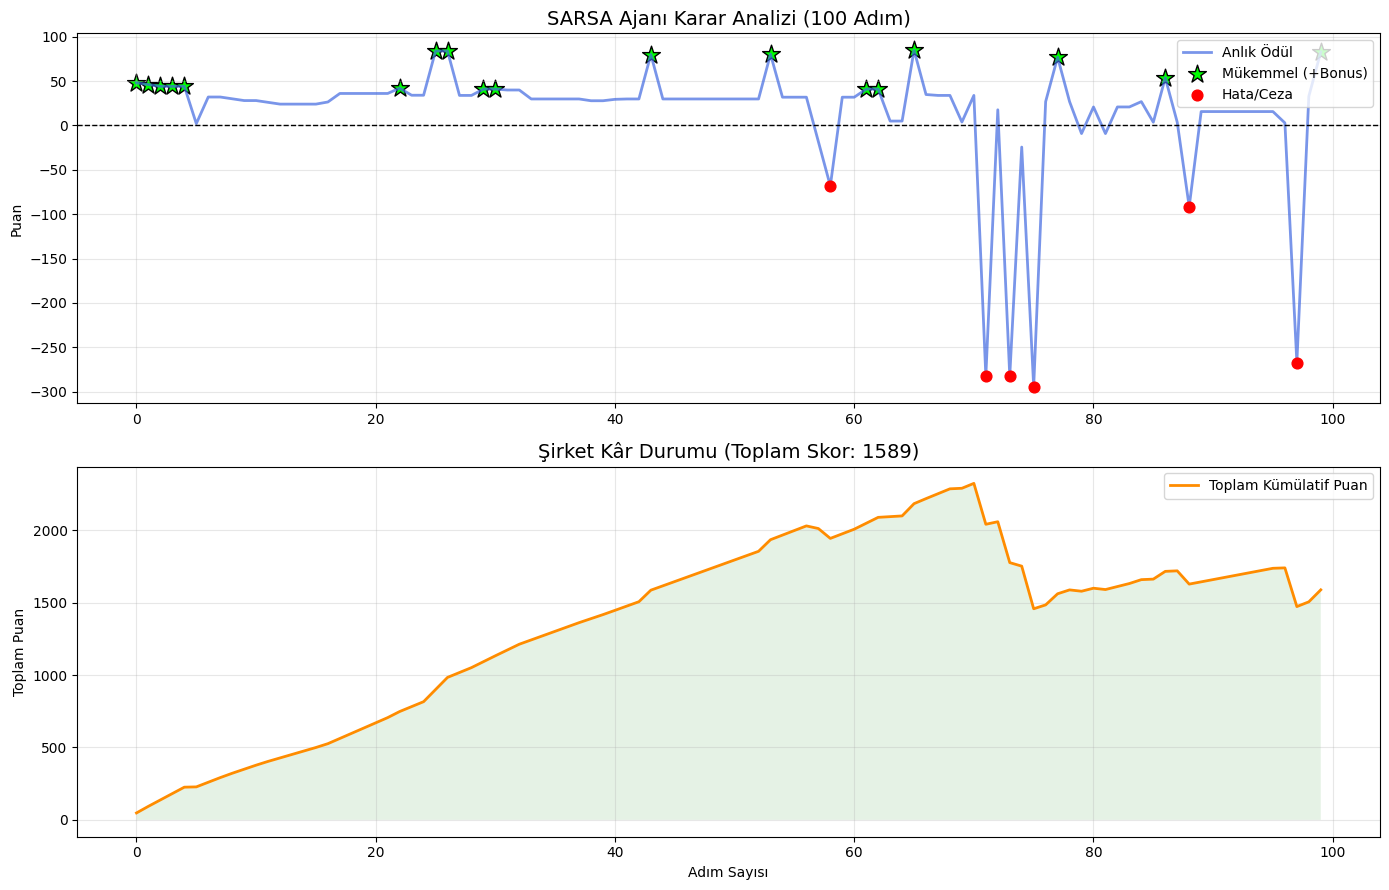


📋 SONUÇ RAPORU:
   🏆 Toplam Puan: 1589
   ✅ Başarılı İş: 90/100
   ⛔ Tip Hatası:  0
   🚀 YORUM: Sistem MÜKEMMEL seviyede optimize edilmiş.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

# ==============================================================================
# 🎬 GELİŞMİŞ TEST VE GÖRSELLEŞTİRME HÜCRESİ
# ==============================================================================
def run_advanced_test(agent, steps=50):
    print(f"\n{'='*70}")
    print(f"🤖 EĞİTİLMİŞ SARSA AJANI TEST EDİLİYOR ({steps} Adım)")
    print(f"{'='*70}")

    # 1. Ajanı Sınav Moduna Al
    agent.epsilon = 0

    # 2. Ortamı Sıfırla
    test_env = OptimizedEnv()
    state = test_env.reset()
    action = agent.choose_action(state) # İlk hamle

    # Veri Saklama Kutuları
    rewards = []
    cumulative_rewards = []
    total_score = 0

    # Grafik İşaretleyicileri
    bonus_x, bonus_y = [], []
    penalty_x, penalty_y = [], []

    # İstatistikler
    success_count = 0
    mismatch_count = 0

    # --- SİMÜLASYON DÖNGÜSÜ ---
    for step in range(1, steps + 1):
        # İş Bilgilerini Al
        job = test_env.current_job
        slack = job['deadline'] / job['size']

        # Simülasyon Adımı (Step)
        next_state, reward, _, _ = test_env.step(action)
        next_action = agent.choose_action(next_state) # SARSA Hamlesi

        # --- LOGLAMA (EKRANA YAZDIRMA) ---
        # İşin Aciliyeti
        if slack < 2.0: urgency_icon = "🚨 KRİTİK"
        elif slack < 4.5: urgency_icon = "⚠️ NORMAL"
        else: urgency_icon = "☕ RAHAT"

        # Zaman Dilimi
        time_text = "☀️ GÜNDÜZ" if test_env.is_daytime else "🌙 GECE"

        print(f"\n⏱️  ADIM {step} | {time_text}")
        print(f"   📦 GELEN İŞ: [{job['type']}] Boyut:{job['size']} | Süre:{job['deadline']:.1f}sn | {urgency_icon}")

        # Seçilen Sunucu
        server = test_env.servers[action] # Şu anki action'ın sunucusu
        tier_names = {0: "HIZLI ", 1: "ORTA ", 2: "YAVAŞ "}

        # Tip Kontrolü
        match_icon = "✅" if job['type'] == server.type else "⛔"
        print(f"   👉 SEÇİM:     [{server.type}] Sunucu {server.id} ({tier_names[server.speed_tier]}) {match_icon}")

        if job['type'] != server.type:
            print(f"      ❌ HATA: Tip uyuşmazlığı! ({job['type']} -> {server.type})")
            mismatch_count += 1

        # Sonuç Yorumu
        if reward > 40:
            print(f"      🌟 SONUÇ: EFSANE! (+{reward:.0f} Puan)")
            success_count += 1
        elif reward > 0:
            print(f"      ✅ SONUÇ: BAŞARILI. (+{reward:.0f} Puan)")
            success_count += 1
        elif reward < -50:
            print(f"      💀 SONUÇ: DEADLINE KAÇTI! ({reward:.0f} Puan)")
        else:
            print(f"      ⚠️ SONUÇ: Vasat. ({reward:.0f} Puan)")

        # --- VERİ KAYDI ---
        rewards.append(reward)
        total_score += reward
        cumulative_rewards.append(total_score)

        if reward > 40: # Bonus
            bonus_x.append(step-1)
            bonus_y.append(reward)
        elif reward < -50: # Ceza
            penalty_x.append(step-1)
            penalty_y.append(reward)

        # İlerle
        state = next_state
        action = next_action

        # Takip edilebilir olsun diye minik bekleme (İstersen kaldırabilirsin)
        # time.sleep(0.1)

    # --- GRAFİK ÇİZİMİ ---
    print(f"\n{'='*70}")
    print("📊 GRAFİKLER OLUŞTURULUYOR...")

    plt.figure(figsize=(14, 9))

    # 1. Grafik: Anlık Kararlar
    plt.subplot(2, 1, 1)
    plt.plot(rewards, color='royalblue', linewidth=2, alpha=0.7, label='Anlık Ödül')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)

    # Olayları İşaretle
    plt.scatter(bonus_x, bonus_y, color='lime', marker='*', s=180, edgecolors='black', label='Mükemmel (+Bonus)')
    plt.scatter(penalty_x, penalty_y, color='red', marker='o', s=60, zorder=5, label='Hata/Ceza')

    plt.title(f"SARSA Ajanı Karar Analizi ({steps} Adım)", fontsize=14)
    plt.ylabel("Puan")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    # 2. Grafik: Kasa Durumu
    plt.subplot(2, 1, 2)
    plt.plot(cumulative_rewards, color='darkorange', linewidth=2, label='Toplam Kümülatif Puan')

    # Alan Boyama
    plt.fill_between(range(steps), cumulative_rewards, 0, where=(np.array(cumulative_rewards)>=0), facecolor='green', alpha=0.1)
    plt.fill_between(range(steps), cumulative_rewards, 0, where=(np.array(cumulative_rewards)<0), facecolor='red', alpha=0.1)

    plt.title(f"Şirket Kâr Durumu (Toplam Skor: {total_score:.0f})", fontsize=14)
    plt.xlabel("Adım Sayısı")
    plt.ylabel("Toplam Puan")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- RAPOR ---
    print(f"\n📋 SONUÇ RAPORU:")
    print(f"   🏆 Toplam Puan: {total_score:.0f}")
    print(f"   ✅ Başarılı İş: {success_count}/{steps}")
    print(f"   ⛔ Tip Hatası:  {mismatch_count}")

    if total_score > 1200:
        print("   🚀 YORUM: Sistem MÜKEMMEL seviyede optimize edilmiş.")
    elif total_score > 0:
        print("   👍 YORUM: Sistem KÂRLI çalışıyor ama iyileştirilebilir.")
    else:
        print("   ⚠️ YORUM: Sistem ZARAR ediyor.")

# --- ÇALIŞTIR ---
try:
    # 100 Adımlık Test
    run_advanced_test(agent, steps=100)
except NameError:
    print("⚠️ HATA: 'agent' bulunamadı. Lütfen önce yukarıdaki eğitim hücresini çalıştırın.")

🚀 TURBO Q-Learning Başlatılıyor (Hedef: 1500+ Puan)...
   -> Bölüm 1000 Bitti. Return: -496.1 (Epsilon: 0.951)
   -> Bölüm 2000 Bitti. Return: -330.6 (Epsilon: 0.905)
   -> Bölüm 3000 Bitti. Return: -1625.1 (Epsilon: 0.861)
   -> Bölüm 4000 Bitti. Return: -742.3 (Epsilon: 0.819)
   -> Bölüm 5000 Bitti. Return: -675.7 (Epsilon: 0.779)
   -> Bölüm 6000 Bitti. Return: 710.3 (Epsilon: 0.741)
   -> Bölüm 7000 Bitti. Return: 726.7 (Epsilon: 0.705)
   -> Bölüm 8000 Bitti. Return: 917.9 (Epsilon: 0.670)
   -> Bölüm 9000 Bitti. Return: 305.0 (Epsilon: 0.638)
   -> Bölüm 10000 Bitti. Return: 142.2 (Epsilon: 0.607)
   -> Bölüm 11000 Bitti. Return: -599.0 (Epsilon: 0.577)
   -> Bölüm 12000 Bitti. Return: 1019.8 (Epsilon: 0.549)
   -> Bölüm 13000 Bitti. Return: -155.8 (Epsilon: 0.522)
   -> Bölüm 14000 Bitti. Return: 655.4 (Epsilon: 0.497)
   -> Bölüm 15000 Bitti. Return: 313.5 (Epsilon: 0.472)
   -> Bölüm 16000 Bitti. Return: 1290.0 (Epsilon: 0.449)
   -> Bölüm 17000 Bitti. Return: 255.3 (Epsilon:

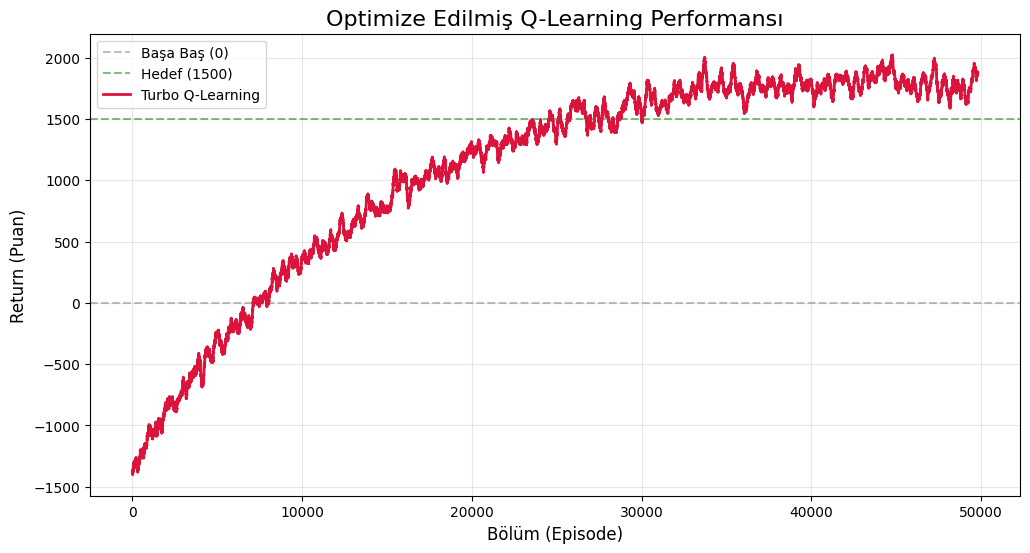

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy

# ==========================================
# 1. GELİŞMİŞ ORTAM (Bonus Artırıldı)
# ==========================================
class Server:
    def __init__(self, s_id, s_type, speed_tier):
        self.id = s_id
        self.type = s_type
        self.queue = 0
        self.is_down = False
        self.repair_time = 0
        self.speed_tier = speed_tier

        # 1. Önce Baz (Temel) Değerleri Belirle
        if speed_tier == 0:   # FAST [$$$]
            base_speed = 5.0
            base_cost = 12.0
        elif speed_tier == 1: # MID [$$]
            base_speed = 2.5
            base_cost = 4.0
        else:                 # SLOW [$]
            base_speed = 1.0
            base_cost = 1.0

        # 2. Tipe Göre Çarpan Uygula (BURASI YENİ EKLENEN KISIM)
        if s_type == "CPU":
            # CPU Sunucuları: %50 Daha Hızlı çalışır ama %50 Daha Pahalıdır
            self.process_speed = base_speed * 1.5
            self.energy_cost = base_cost * 1.5
        else:
            # IO Sunucuları: Standart hız ve fiyattadır
            self.process_speed = base_speed * 1.0
            self.energy_cost = base_cost * 1.0

    def do_work(self):
        if self.is_down:
            self.repair_time -= 1
            if self.repair_time <= 0: self.is_down = False
            return 0

        work = min(self.queue, self.process_speed)
        self.queue -= work
        return work * self.energy_cost

    def do_work(self):
        if self.is_down:
            self.repair_time -= 1
            if self.repair_time <= 0: self.is_down = False
            return 0

        work = min(self.queue, self.process_speed)
        self.queue -= work
        return work * self.energy_cost

class OptimizedEnv:
    def __init__(self):
        self.n_servers = 60
        self.servers = []
        for i in range(60):
            s_type = "CPU" if i < 30 else "IO"
            tier = 0 if (i%30)<10 else (1 if (i%30)<20 else 2)
            self.servers.append(Server(i, s_type, tier))
        self.current_job = self._generate_job()
        self.action_space_n = 60
        self.is_daytime = True

    def reset(self):
        for s in self.servers:
            s.queue = 0
            s.is_down = False
        self.current_job = self._generate_job()
        return self._get_state()

    def _generate_job(self):
        size = random.randint(20, 100)
        # Slack (Rahatlık) payını biraz daha cömert yapalım ki Yavaş Sunucu kullanılabilsin
        slack = random.uniform(1.2, 7.0)
        deadline = size / 1.0 * slack
        j_type = random.choice(["CPU", "IO"])
        return {"size": size, "deadline": deadline, "type": j_type}

    def _get_state(self):
        j_type = 0 if self.current_job["type"] == "CPU" else 1
        size_bucket = 1 if self.current_job["size"] > 60 else 0

        # State'e daha ince ayar: Urgency (Aciliyet) seviyesi 3'e çıkarıldı
        job_slack = self.current_job["deadline"] / self.current_job["size"]
        if job_slack < 2.0: urgency = 2 # Kritik
        elif job_slack < 4.5: urgency = 1 # Normal
        else: urgency = 0 # Çok Rahat

        price = 1 if self.is_daytime else 0
        return f"{j_type}-{size_bucket}-{urgency}-{price}"

    def step(self, action):
        target_server = self.servers[action]
        reward = 0
        job = self.current_job

        # 1. Tahmini Süre Kontrolü
        completion_time = (target_server.queue + job["size"]) / target_server.process_speed

        if completion_time <= job["deadline"]:
            reward += 20 # Standart Başarı

            # --- İYİLEŞTİRME: BONUSLAR ARTIRILDI ---
            if target_server.speed_tier == 2: # Yavaş
                reward += 80 # Eskiden 50 idi -> Şimdi 80 (Cazibe Merkezi)
            elif target_server.speed_tier == 1: # Orta
                reward += 30 # Eskiden 20 idi
        else:
            reward -= 250 # Ceza aynı

        # 2. İş Ekleme
        target_server.queue += job["size"]
        if target_server.type != job["type"]: reward -= 50

        # 3. Simülasyon
        total_energy = 0
        price_mult = 2.0 if self.is_daytime else 1.0
        for s in self.servers:
            energy = s.do_work()
            total_energy += energy
            # Arıza
            if not s.is_down and random.random() < 0.0005:
                s.is_down = True
                s.repair_time = 10
                reward -= 100

        reward -= (total_energy * price_mult * 0.1)
        if random.random() < 0.05: self.is_daytime = not self.is_daytime
        self.current_job = self._generate_job()

        return self._get_state(), reward, False, {}

# ==========================================
# 2. TURBO Q-LEARNING AJANI
# ==========================================
class TurboQLearningAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.q_table = {}

        # --- İYİLEŞTİRME: HİPERPARAMETRELER ---
        self.lr = 0.1
        self.gamma = 0.95      # Daha ileri görüşlü (Eskiden 0.9)
        self.epsilon = 1.0
        self.epsilon_min = 0.01 # Keşfi asla tamamen kapatma
        self.epsilon_decay = 0.99995 # ÇOK YAVAŞ AZALMA (Daha uzun öğrenme)

    def get_q(self, state):
        if state not in self.q_table:
            # --- İYİLEŞTİRME: OPTIMISTIC INITIALIZATION ---
            # Her yere 100 puan veriyoruz. Ajan "Burası kesin harikadır" diyip deneyecek.
            self.q_table[state] = np.ones(self.action_space) * 100.0
        return self.q_table[state]

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_space - 1)
        return np.argmax(self.get_q(state))

    def update(self, state, action, reward, next_state):
        q_current = self.get_q(state)[action]
        q_target = reward + self.gamma * np.max(self.get_q(next_state))
        self.q_table[state][action] += self.lr * (q_target - q_current)

# ==========================================
# 3. EĞİTİM (Daha Uzun Süre)
# ==========================================
if __name__ == "__main__":
    print("🚀 TURBO Q-Learning Başlatılıyor (Hedef: 1500+ Puan)...")

    # Bölüm sayısını artırıyoruz çünkü epsilon yavaş azalıyor
    EPISODES = 50000

    env = OptimizedEnv()
    agent = TurboQLearningAgent(env.action_space_n)
    rewards = []

    for episode in range(EPISODES):
        state = env.reset()
        total_r = 0

        for _ in range(50):
            action = agent.choose_action(state)
            next_state, reward, _, _ = env.step(action)
            agent.update(state, action, reward, next_state)
            state = next_state
            total_r += reward

        # Decay işlemi
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        rewards.append(total_r)

        if (episode+1) % 1000 == 0:
            print(f"   -> Bölüm {episode+1} Bitti. Return: {total_r:.1f} (Epsilon: {agent.epsilon:.3f})")

    # --- GRAFİK ---
    print("\n📈 Sonuçlar Çiziliyor...")

    # Kayan ortalama penceresini genişlettim ki trend net görülsün
    window = 200
    smoothed_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(12, 6))

    # Hedef bölgeleri çiz
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5, label="Başa Baş (0)")
    plt.axhline(1500, color='green', linestyle='--', alpha=0.5, label="Hedef (1500)")

    plt.plot(smoothed_rewards, color='crimson', linewidth=2, label="Turbo Q-Learning")

    plt.title("Optimize Edilmiş Q-Learning Performansı", fontsize=16)
    plt.xlabel("Bölüm (Episode)", fontsize=12)
    plt.ylabel("Return (Puan)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [2]:
import time

# ==============================================================
# 🎬 TAM KAPSAMLI SİMÜLASYON (Görsel İyileştirilmiş)
# ==============================================================
def run_full_simulation(agent, steps=20):
    print(f"\n{'='*70}")
    print(f"🤖 TURBO AJAN SAHADA: Tip Eşleşmesi ve Maliyet Kontrolü")
    print(f"{'='*70}")

    agent.epsilon = 0 # Sınav modu
    test_env = OptimizedEnv()
    state = test_env.reset()

    total_score = 0
    success_count = 0
    mismatch_count = 0

    for step in range(1, steps + 1):
        job = test_env.current_job
        slack = job['deadline'] / job['size']

        if slack < 2.0: urgency_icon = "🚨 KRİTİK"
        elif slack < 4.5: urgency_icon = "⚠️ NORMAL"
        else: urgency_icon = "☕ RAHAT"

        time_text = "☀️ GÜNDÜZ (Pahalı)" if test_env.is_daytime else "🌙 GECE (Ucuz)"

        print(f"\n⏱️  ADIM {step} | {time_text}")
        print(f"   📦 GELEN İŞ:  [{job['type']}]  | Boyut: {job['size']} br | Süre: {job['deadline']:.1f}sn | {urgency_icon}")

        action = agent.choose_action(state)
        server = test_env.servers[action]

        # --- GÖRSEL İYİLEŞTİRME BURADA ---
        if server.type == "CPU":
            tier_names = {0: "HIZLI [$$$$]", 1: "ORTA [$$$]", 2: "YAVAŞ [$$]"}
        else:
            tier_names = {0: "HIZLI [$$]", 1: "ORTA [$]", 2: "YAVAŞ [¢]"}

        server_desc = tier_names[server.speed_tier]

        match_icon = "✅" if job['type'] == server.type else "❌"
        match_text = "UYUMLU" if job['type'] == server.type else "UYUMSUZ"

        print(f"   👉 SEÇİM:      [{server.type}] Sunucu {server.id} ({server_desc})")

        if job['type'] != server.type:
            print(f"      ⛔ HATA: {job['type']} işi, {server.type} sunucusuna atıldı! (Performans Kaybı)")
            mismatch_count += 1
        else:
            print(f"      ✨ Tip Kontrolü: {match_icon} {match_text}")

        next_state, reward, _, _ = test_env.step(action)

        if server.is_down:
             print(f"      🔥 KRİTİK: Sunucu işlem sırasında ARIZA verdi!")

        if reward > 50:
            print(f"      🌟 SONUÇ: EFSANE! (+{reward:.0f} Puan)")
            success_count += 1
        elif reward > 0:
            print(f"      ✅ SONUÇ: BAŞARILI. (+{reward:.0f} Puan)")
            success_count += 1
        elif reward <= -200:
            print(f"      💀 SONUÇ: DEADLINE KAÇTI! ({reward:.0f} Puan)")
        else:
            print(f"      ⚠️ SONUÇ: Vasat. ({reward:.0f} Puan)")

        print("-" * 70)
        total_score += reward
        state = next_state
        time.sleep(0.8) # Biraz hızlandırdım

    print(f"\n📊 RAPOR:")
    print(f"   - Toplam Puan: {total_score:.0f}")
    print(f"   - Başarılı İş: {success_count}/{steps}")
    print(f"   - Tip Hatası:  {mismatch_count}")

# --- ÇALIŞTIR ---
try:
    run_full_simulation(agent, steps=20)
except NameError:
    print("⚠️ HATA: Lütfen önce yukarıdaki 'Eğitim' kodunu çalıştırın.")


🤖 TURBO AJAN SAHADA: Tip Eşleşmesi ve Maliyet Kontrolü

⏱️  ADIM 1 | ☀️ GÜNDÜZ (Pahalı)
   📦 GELEN İŞ:  [CPU]  | Boyut: 75 br | Süre: 328.7sn | ⚠️ NORMAL
   👉 SEÇİM:      [CPU] Sunucu 13 (ORTA [$$$])
      ✨ Tip Kontrolü: ✅ UYUMLU
      ✅ SONUÇ: BAŞARILI. (+46 Puan)
----------------------------------------------------------------------

⏱️  ADIM 2 | ☀️ GÜNDÜZ (Pahalı)
   📦 GELEN İŞ:  [IO]  | Boyut: 90 br | Süre: 523.2sn | ☕ RAHAT
   👉 SEÇİM:      [IO] Sunucu 58 (YAVAŞ [¢])
      ✨ Tip Kontrolü: ✅ UYUMLU
      🌟 SONUÇ: EFSANE! (+95 Puan)
----------------------------------------------------------------------

⏱️  ADIM 3 | ☀️ GÜNDÜZ (Pahalı)
   📦 GELEN İŞ:  [CPU]  | Boyut: 46 br | Süre: 130.9sn | ⚠️ NORMAL
   👉 SEÇİM:      [CPU] Sunucu 11 (ORTA [$$$])
      ✨ Tip Kontrolü: ✅ UYUMLU
      ✅ SONUÇ: BAŞARILI. (+41 Puan)
----------------------------------------------------------------------

⏱️  ADIM 4 | ☀️ GÜNDÜZ (Pahalı)
   📦 GELEN İŞ:  [IO]  | Boyut: 74 br | Süre: 204.2sn | ⚠️ NORMAL
   👉

📊 GRAFİKLİ TEST BAŞLIYOR (100 Adım)...


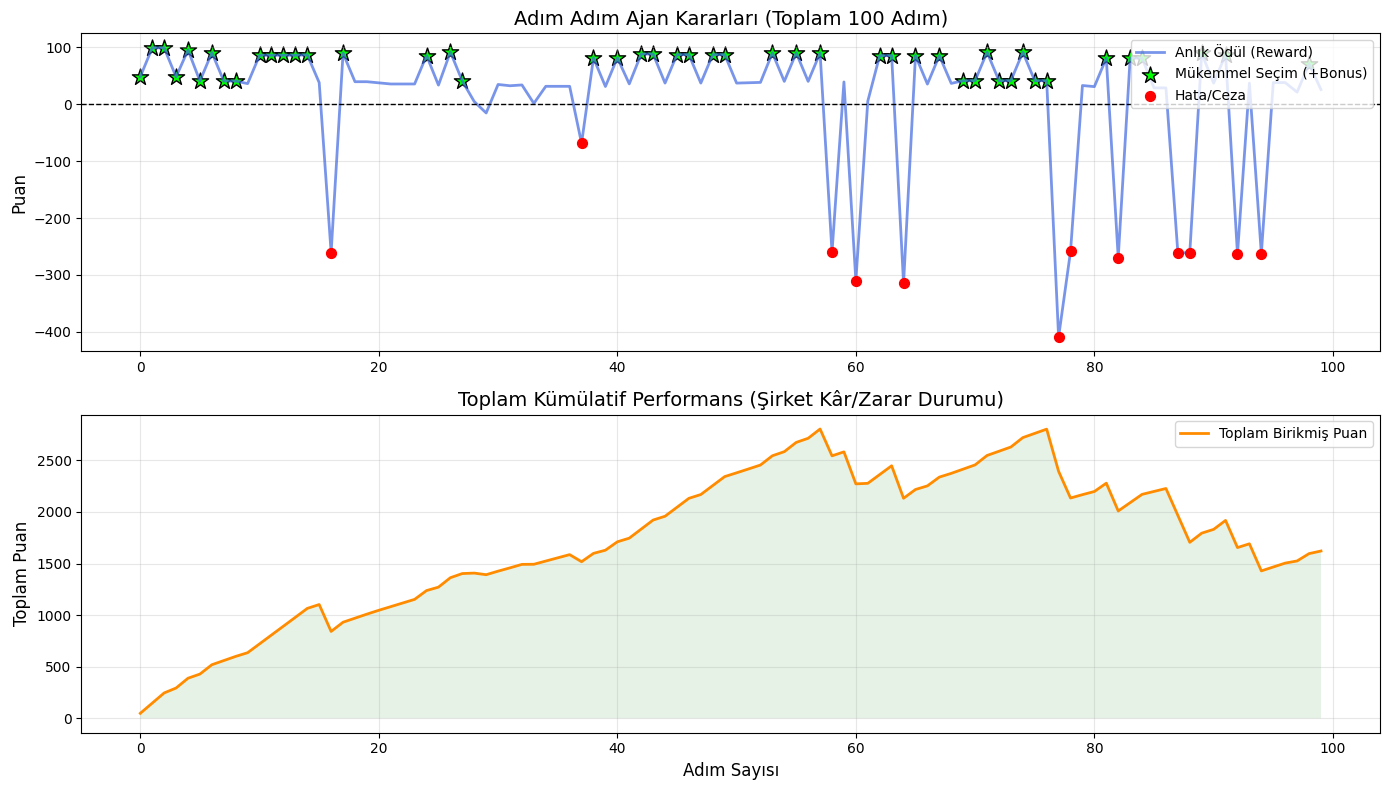

🏆 TEST SONUCU: Toplam Puan = 1621
✅ YORUM: Sistem KÂRLI çalışıyor.


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def test_and_plot_results(agent, steps=50):
    print(f"📊 GRAFİKLİ TEST BAŞLIYOR ({steps} Adım)...")

    # Ajanı Sınav Moduna Al
    agent.epsilon = 0
    test_env = OptimizedEnv()
    state = test_env.reset()

    rewards = []         # Her adımın anlık puanı
    cumulative_rewards = [] # Kümülatif toplam puan
    total_score = 0

    # Olayları işaretlemek için listeler
    bonus_events_x = []  # Bonus alınan adımlar
    bonus_events_y = []
    penalty_events_x = [] # Ceza yenilen adımlar
    penalty_events_y = []

    for step in range(steps):
        # Karar Ver
        action = agent.choose_action(state)

        # Uygula
        next_state, reward, _, _ = test_env.step(action)

        # Verileri Kaydet
        rewards.append(reward)
        total_score += reward
        cumulative_rewards.append(total_score)

        # Olay İşaretleme (Grafik için)
        if reward > 40: # Bonus (Yeşil Yıldız)
            bonus_events_x.append(step)
            bonus_events_y.append(reward)
        elif reward < -50: # Ceza (Kırmızı Nokta)
            penalty_events_x.append(step)
            penalty_events_y.append(reward)

        state = next_state

    # --- GRAFİK ÇİZİMİ ---
    plt.figure(figsize=(14, 8))

    # 1. GRAFİK: Anlık Performans (Her Adım)
    plt.subplot(2, 1, 1)
    plt.plot(rewards, color='royalblue', linewidth=2, label='Anlık Ödül (Reward)', alpha=0.7)
    plt.axhline(0, color='black', linestyle='--', linewidth=1) # Sıfır noktası

    # Olayları üzerine çiz
    plt.scatter(bonus_events_x, bonus_events_y, color='lime', marker='*', s=150, edgecolors='black', label='Mükemmel Seçim (+Bonus)')
    plt.scatter(penalty_events_x, penalty_events_y, color='red', marker='o', s=50, zorder=5, label='Hata/Ceza')

    plt.title(f"Adım Adım Ajan Kararları (Toplam {steps} Adım)", fontsize=14)
    plt.ylabel("Puan", fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    # 2. GRAFİK: Kümülatif Kazanç (Kasa Durumu)
    plt.subplot(2, 1, 2)
    # Renk durumu: Kârda ise Yeşil, Zararda ise Kırmızı dolgu
    plt.plot(cumulative_rewards, color='darkorange', linewidth=2, label='Toplam Birikmiş Puan')

    # Alanı boyama
    x_axis = range(len(cumulative_rewards))
    plt.fill_between(x_axis, cumulative_rewards, 0, where=(np.array(cumulative_rewards) >= 0), facecolor='green', alpha=0.1)
    plt.fill_between(x_axis, cumulative_rewards, 0, where=(np.array(cumulative_rewards) < 0), facecolor='red', alpha=0.1)

    plt.title("Toplam Kümülatif Performans (Şirket Kâr/Zarar Durumu)", fontsize=14)
    plt.xlabel("Adım Sayısı", fontsize=12)
    plt.ylabel("Toplam Puan", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"🏆 TEST SONUCU: Toplam Puan = {total_score:.0f}")
    if total_score > 0:
        print("✅ YORUM: Sistem KÂRLI çalışıyor.")
    else:
        print("⚠️ YORUM: Sistem ZARAR ediyor, optimizasyon lazım.")

# --- ÇALIŞTIR ---
try:
    # 100 adımlık bir test yapalım ki grafik güzel görünsün
    test_and_plot_results(agent, steps=100)
except NameError:
    print("⚠️ HATA: 'agent' hafızada yok. Lütfen önce eğitim kodunu çalıştır.")

🚀 SARSA EĞİTİMİ BAŞLIYOR (CPU > IO Senaryosu, 50.000 Bölüm)...
   -> Bölüm 5000/50000 Tamamlandı. (6.9 sn) | Return: 1094.9 | Epsilon: 0.6065
   -> Bölüm 10000/50000 Tamamlandı. (13.9 sn) | Return: 2066.8 | Epsilon: 0.3679
   -> Bölüm 15000/50000 Tamamlandı. (21.0 sn) | Return: 1811.4 | Epsilon: 0.2231
   -> Bölüm 20000/50000 Tamamlandı. (28.1 sn) | Return: 814.0 | Epsilon: 0.1353
   -> Bölüm 25000/50000 Tamamlandı. (35.0 sn) | Return: 1804.2 | Epsilon: 0.0821
   -> Bölüm 30000/50000 Tamamlandı. (42.2 sn) | Return: 1385.0 | Epsilon: 0.0498
   -> Bölüm 35000/50000 Tamamlandı. (49.3 sn) | Return: 1172.1 | Epsilon: 0.0302
   -> Bölüm 40000/50000 Tamamlandı. (56.4 sn) | Return: 1124.8 | Epsilon: 0.0183
   -> Bölüm 45000/50000 Tamamlandı. (63.8 sn) | Return: 1674.2 | Epsilon: 0.0111
   -> Bölüm 50000/50000 Tamamlandı. (71.0 sn) | Return: 1619.7 | Epsilon: 0.0067

✅ EĞİTİM TAMAMLANDI!

📈 Eğitim Grafiği Çiziliyor...


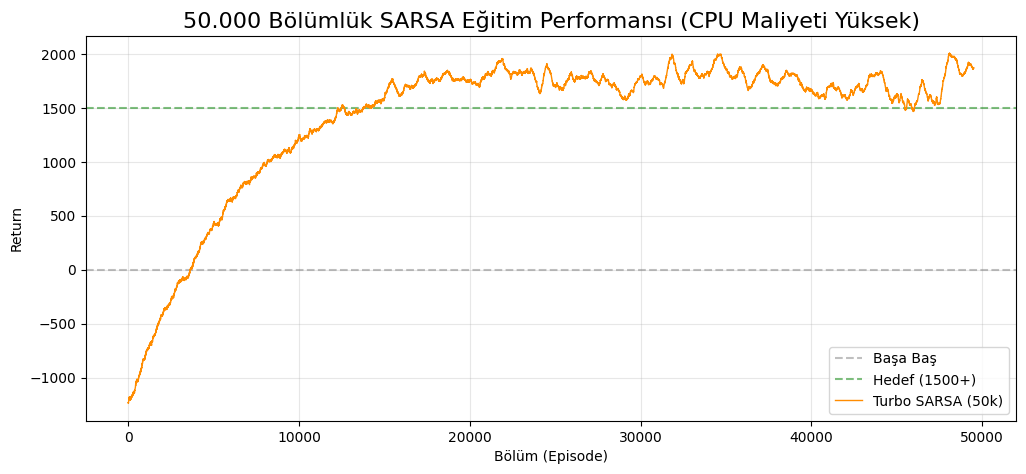


📊 SARSA İLE DETAYLI SİMÜLASYON TESTİ (100 Adım)...


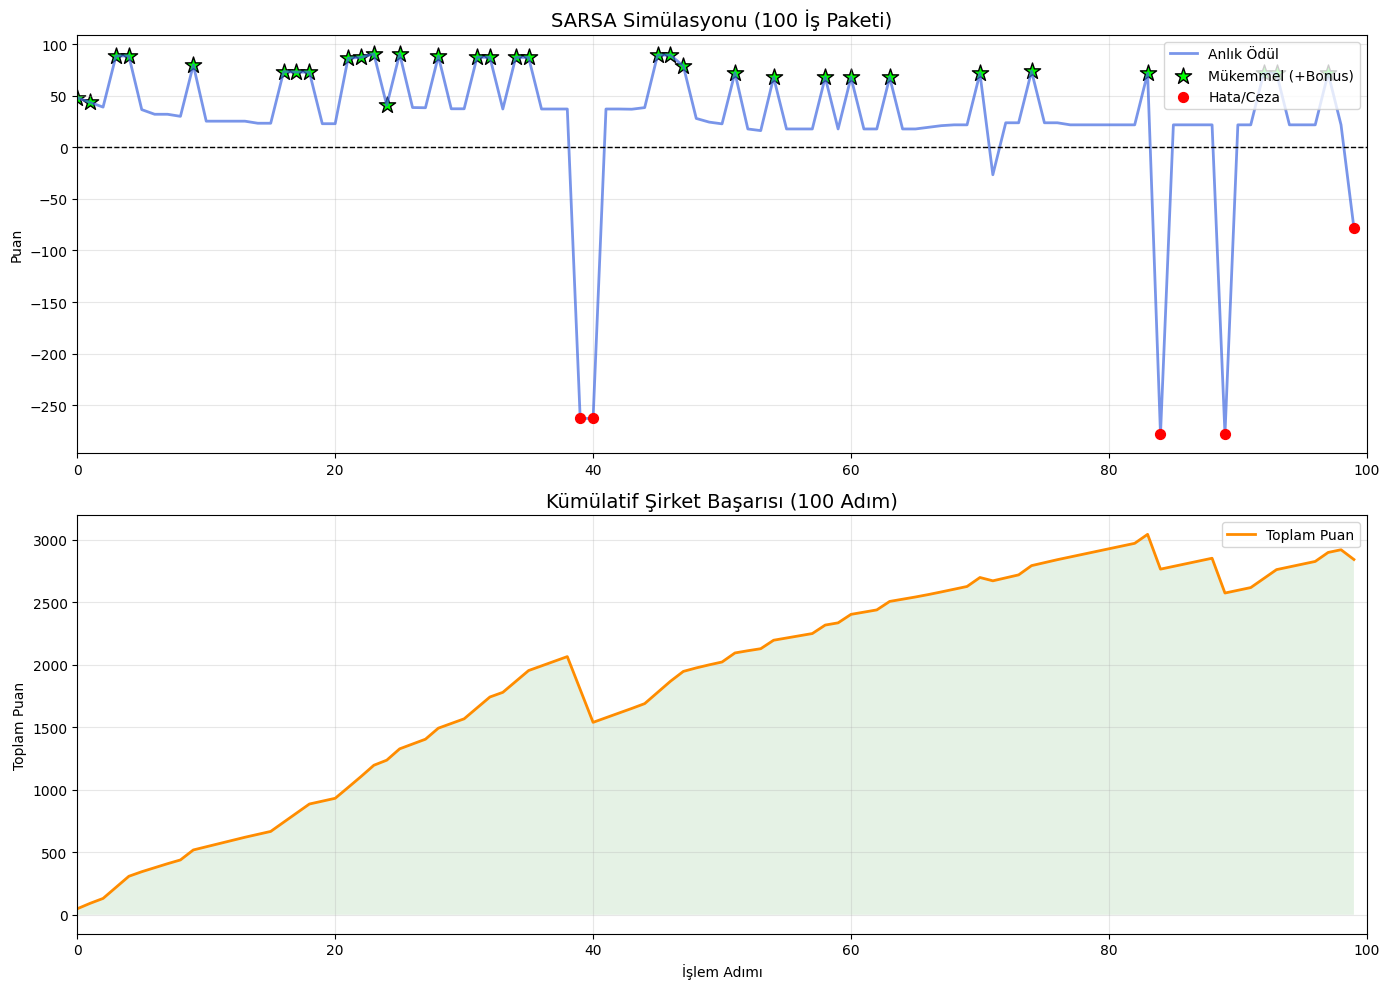

🏆 100 ADIMLIK SARSA TEST SONUCU: Toplam Puan = 2841
✅ YORUM: SARSA, uzun test sürecinde mükemmel bir istikrar gösterdi.


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

# ==============================================================================
# 1. OPTİMİZE ORTAM (CPU > IO Farkı Eklendi)
# ==============================================================================
class Server:
    def __init__(self, s_id, s_type, speed_tier):
        self.id = s_id
        self.type = s_type
        self.queue = 0
        self.is_down = False
        self.repair_time = 0
        self.speed_tier = speed_tier

        # --- GÜNCELLEME: CPU HIZ VE MALİYET FARKI ---

        # 1. Baz (Temel) Değerleri Belirle
        if speed_tier == 0:   # FAST [$$$]
            base_speed = 5.0
            base_cost = 12.0
        elif speed_tier == 1: # MID [$$]
            base_speed = 2.5
            base_cost = 4.0
        else:                 # SLOW [$]
            base_speed = 1.0
            base_cost = 1.0

        # 2. Tipe Göre Çarpan Uygula
        if s_type == "CPU":
            # CPU Sunucuları: %50 Daha Hızlı çalışır ama %50 Daha Pahalıdır
            self.process_speed = base_speed * 1.5
            self.energy_cost = base_cost * 1.5
        else:
            # IO Sunucuları: Standart hız ve fiyattadır
            self.process_speed = base_speed * 1.0
            self.energy_cost = base_cost * 1.0

    def do_work(self):
        if self.is_down:
            self.repair_time -= 1
            if self.repair_time <= 0: self.is_down = False
            return 0

        work = min(self.queue, self.process_speed)
        self.queue -= work
        return work * self.energy_cost

class OptimizedEnv:
    def __init__(self):
        self.n_servers = 60
        self.servers = []
        for i in range(60):
            s_type = "CPU" if i < 30 else "IO"
            tier = 0 if (i%30)<10 else (1 if (i%30)<20 else 2)
            self.servers.append(Server(i, s_type, tier))
        self.current_job = self._generate_job()
        self.action_space_n = 60
        self.is_daytime = True

    def reset(self):
        for s in self.servers:
            s.queue = 0
            s.is_down = False
        self.current_job = self._generate_job()
        return self._get_state()

    def _generate_job(self):
        size = random.randint(20, 100)
        slack = random.uniform(1.2, 7.0)
        deadline = size / 1.0 * slack
        j_type = random.choice(["CPU", "IO"])
        return {"size": size, "deadline": deadline, "type": j_type}

    def _get_state(self):
        j_type = 0 if self.current_job["type"] == "CPU" else 1
        size_bucket = 1 if self.current_job["size"] > 60 else 0
        job_slack = self.current_job["deadline"] / self.current_job["size"]
        if job_slack < 2.0: urgency = 2
        elif job_slack < 4.5: urgency = 1
        else: urgency = 0
        price = 1 if self.is_daytime else 0
        return f"{j_type}-{size_bucket}-{urgency}-{price}"

    def step(self, action):
        target_server = self.servers[action]
        reward = 0
        job = self.current_job

        # 1. Tahmini Süre ve Bonuslar
        completion_time = (target_server.queue + job["size"]) / target_server.process_speed

        if completion_time <= job["deadline"]:
            reward += 20
            if target_server.speed_tier == 2: reward += 80
            elif target_server.speed_tier == 1: reward += 30
        else:
            reward -= 250

        # 2. İş Ekleme
        target_server.queue += job["size"]
        if target_server.type != job["type"]: reward -= 50

        # 3. Simülasyon
        total_energy = 0
        price_mult = 2.0 if self.is_daytime else 1.0
        for s in self.servers:
            energy = s.do_work()
            total_energy += energy
            if not s.is_down and random.random() < 0.0005:
                s.is_down = True
                s.repair_time = 10
                reward -= 100

        reward -= (total_energy * price_mult * 0.1)
        if random.random() < 0.05: self.is_daytime = not self.is_daytime
        self.current_job = self._generate_job()

        return self._get_state(), reward, False, {}

# ==============================================================================
# 2. TURBO SARSA AJANI (50k Bölüm İçin Ayarlandı)
# ==============================================================================
class TurboSarsaAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.q_table = {}

        self.lr = 0.1
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.9999

    def get_q(self, state):
        if state not in self.q_table:
            # Optimistic Initialization
            self.q_table[state] = np.ones(self.action_space) * 100.0
        return self.q_table[state]

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_space - 1)
        return np.argmax(self.get_q(state))

    def update(self, state, action, reward, next_state, next_action):
        q_current = self.get_q(state)[action]
        q_next = self.get_q(next_state)[next_action]

        target = reward + self.gamma * q_next
        self.q_table[state][action] += self.lr * (target - q_current)

# ==============================================================================
# 3. EĞİTİM (50.000 EPISODE)
# ==============================================================================
print("🚀 SARSA EĞİTİMİ BAŞLIYOR (CPU > IO Senaryosu, 50.000 Bölüm)...")

EPISODES = 50000

env = OptimizedEnv()
agent = TurboSarsaAgent(env.action_space_n)
rewards = []

start_time = time.time()

for episode in range(EPISODES):
    state = env.reset()

    # SARSA Başlangıcı: State -> Action
    action = agent.choose_action(state)

    total_r = 0

    # Eğitim döngüsü
    for _ in range(50):
        next_state, reward, _, _ = env.step(action)
        next_action = agent.choose_action(next_state)

        agent.update(state, action, reward, next_state, next_action)

        state = next_state
        action = next_action
        total_r += reward

    # Decay
    agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
    rewards.append(total_r)

    if (episode+1) % 5000 == 0:
        elapsed = time.time() - start_time
        print(f"   -> Bölüm {episode+1}/{EPISODES} Tamamlandı. ({elapsed:.1f} sn) | Return: {total_r:.1f} | Epsilon: {agent.epsilon:.4f}")

print("\n✅ EĞİTİM TAMAMLANDI!")

# ==============================================================================
# 4. GRAFİK VE 100 ADIMLIK SİMÜLASYON TESTİ
# ==============================================================================
# --- A. EĞİTİM GRAFİĞİ ---
print("\n📈 Eğitim Grafiği Çiziliyor...")
window = 500
smoothed_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12, 5))
plt.axhline(0, color='gray', linestyle='--', alpha=0.5, label="Başa Baş")
plt.axhline(1500, color='green', linestyle='--', alpha=0.5, label="Hedef (1500+)")
plt.plot(smoothed_rewards, color='darkorange', linewidth=1, label="Turbo SARSA (50k)")
plt.title("50.000 Bölümlük SARSA Eğitim Performansı (CPU Maliyeti Yüksek)", fontsize=16)
plt.xlabel("Bölüm (Episode)")
plt.ylabel("Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- B. DETAYLI SİMÜLASYON TESTİ (100 ADIM) ---
print(f"\n📊 SARSA İLE DETAYLI SİMÜLASYON TESTİ (100 Adım)...")

agent.epsilon = 0 # Sınav modu
test_env = OptimizedEnv()
state = test_env.reset()
action = agent.choose_action(state)

test_rewards = []
cumulative_rewards = []
total_score = 0
bonus_x, bonus_y = [], []
penalty_x, penalty_y = [], []

# 100 Adımlık Test Döngüsü
TEST_STEPS = 100

for step in range(TEST_STEPS):
    next_state, reward, _, _ = test_env.step(action)
    next_action = agent.choose_action(next_state)

    # Veri Kayıt
    test_rewards.append(reward)
    total_score += reward
    cumulative_rewards.append(total_score)

    if reward > 40: # Bonus (Yeşil Yıldız)
        bonus_x.append(step)
        bonus_y.append(reward)
    elif reward < -50: # Ceza (Kırmızı Nokta)
        penalty_x.append(step)
        penalty_y.append(reward)

    state = next_state
    action = next_action

# Simülasyon Grafikleri
plt.figure(figsize=(14, 10))

# 1. Anlık Kararlar Grafiği
plt.subplot(2, 1, 1)
plt.plot(test_rewards, color='royalblue', linewidth=2, alpha=0.7, label='Anlık Ödül')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.scatter(bonus_x, bonus_y, color='lime', marker='*', s=150, edgecolors='black', label='Mükemmel (+Bonus)')
plt.scatter(penalty_x, penalty_y, color='red', marker='o', s=50, zorder=5, label='Hata/Ceza')
plt.title(f"SARSA Simülasyonu ({TEST_STEPS} İş Paketi)", fontsize=14)
plt.ylabel("Puan")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
# X eksenini 100 adıma göre ayarlayalım
plt.xlim(0, TEST_STEPS)

# 2. Kasa Durumu Grafiği (Kümülatif)
plt.subplot(2, 1, 2)
plt.plot(cumulative_rewards, color='darkorange', linewidth=2, label='Toplam Puan')
# DÜZELTİLEN KISIM: range(TEST_STEPS) kullanıldı
plt.fill_between(range(TEST_STEPS), cumulative_rewards, 0, where=(np.array(cumulative_rewards)>=0), facecolor='green', alpha=0.1)
plt.fill_between(range(TEST_STEPS), cumulative_rewards, 0, where=(np.array(cumulative_rewards)<0), facecolor='red', alpha=0.1)

plt.title("Kümülatif Şirket Başarısı (100 Adım)", fontsize=14)
plt.xlabel("İşlem Adımı")
plt.ylabel("Toplam Puan")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, TEST_STEPS)

plt.tight_layout()
plt.show()

print(f"🏆 {TEST_STEPS} ADIMLIK SARSA TEST SONUCU: Toplam Puan = {total_score:.0f}")

if total_score > 2000:
    print("✅ YORUM: SARSA, uzun test sürecinde mükemmel bir istikrar gösterdi.")
elif total_score > 1000:
    print("👍 YORUM: Sistem kârlı çalışıyor, güvenli limanda.")
else:
    print("⚠️ YORUM: Uzun vadede riskler oluştu.")


🤖 SARSA AJANI TEST EDİLİYOR (100 Adım) - Maliyet & Hız Analizi

⏱️  ADIM 1 | ☀️ GÜNDÜZ (Pahalı)
   📦 GELEN İŞ: [CPU] Boyut:26 | Süre:90.7sn | ⚠️ NORMAL
   👉 SEÇİM:     [CPU] Sunucu 13 (ORTA [$$$]) ✅
      🌟 SONUÇ: EFSANE! (+46 Puan)

⏱️  ADIM 2 | ☀️ GÜNDÜZ (Pahalı)
   📦 GELEN İŞ: [IO] Boyut:92 | Süre:604.3sn | ☕ RAHAT
   👉 SEÇİM:     [IO] Sunucu 46 (ORTA [$]) ✅
      🌟 SONUÇ: EFSANE! (+44 Puan)

⏱️  ADIM 3 | ☀️ GÜNDÜZ (Pahalı)
   📦 GELEN İŞ: [CPU] Boyut:33 | Süre:54.2sn | 🚨 KRİTİK
   👉 SEÇİM:     [CPU] Sunucu 12 (ORTA [$$$]) ✅
      ✅ SONUÇ: BAŞARILI. (+39 Puan)

⏱️  ADIM 4 | ☀️ GÜNDÜZ (Pahalı)
   📦 GELEN İŞ: [CPU] Boyut:38 | Süre:249.3sn | ☕ RAHAT
   👉 SEÇİM:     [CPU] Sunucu 24 (YAVAŞ [$$]) ✅
      🌟 SONUÇ: EFSANE! (+89 Puan)

⏱️  ADIM 5 | ☀️ GÜNDÜZ (Pahalı)
   📦 GELEN İŞ: [CPU] Boyut:68 | Süre:229.7sn | ⚠️ NORMAL
   👉 SEÇİM:     [CPU] Sunucu 10 (ORTA [$$$]) ✅
      ✅ SONUÇ: BAŞARILI. (+34 Puan)

⏱️  ADIM 6 | ☀️ GÜNDÜZ (Pahalı)
   📦 GELEN İŞ: [CPU] Boyut:40 | Süre:206.5sn | ☕ RAHAT


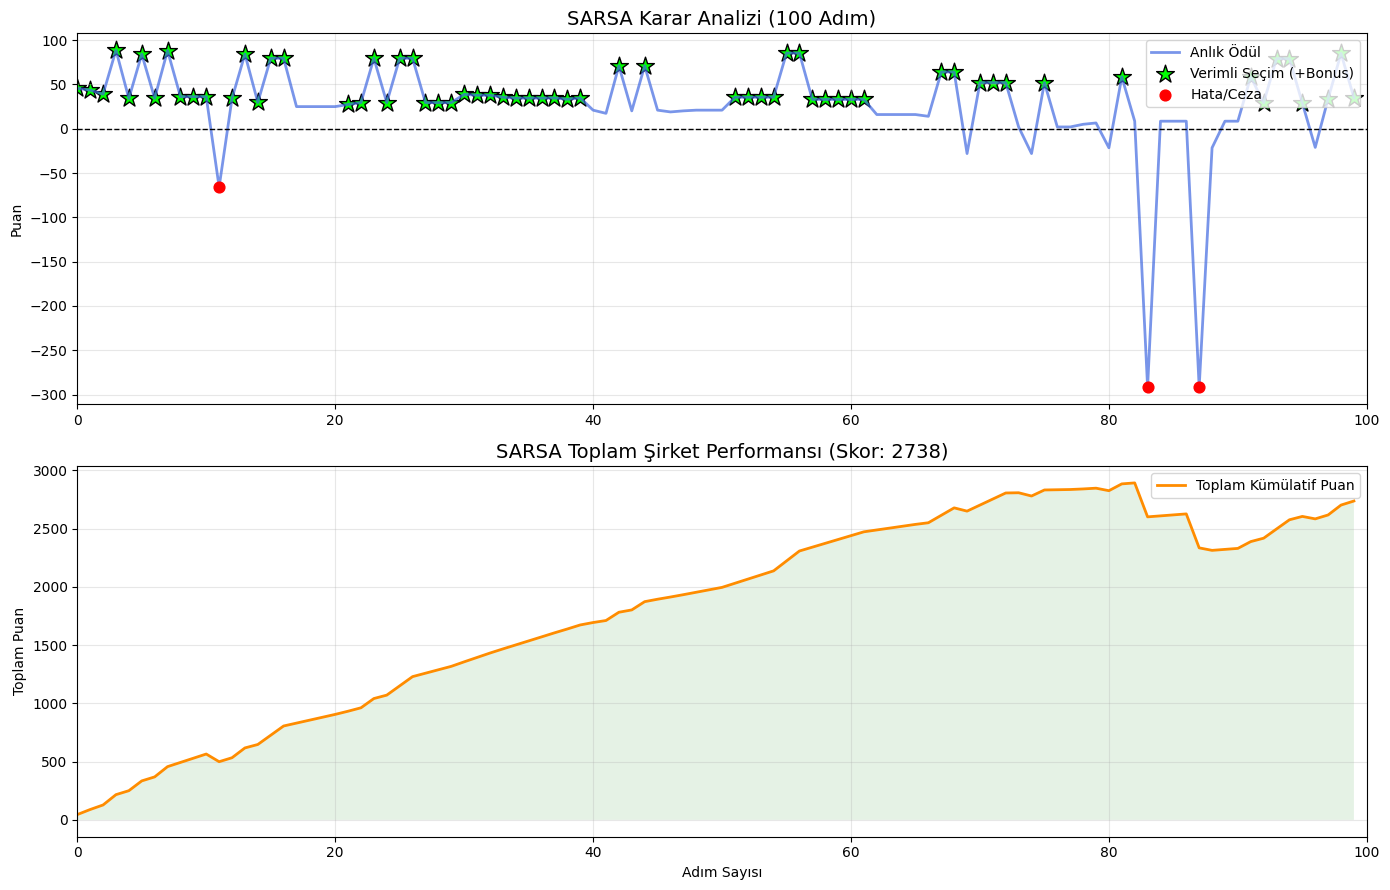


📋 SONUÇ RAPORU:
   🏆 Toplam Puan: 2738
   ✅ Başarılı İş: 92/100
   ⛔ Tip Hatası:  0
   🚀 YORUM: Sistem MÜKEMMEL seviyede optimize edilmiş.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time

# ==============================================================================
# 🎬 GELİŞMİŞ TEST VE GÖRSELLEŞTİRME HÜCRESİ (GÜNCELLENDİ)
# ==============================================================================
def run_advanced_test(agent, alg_name="SARSA", steps=100):
    print(f"\n{'='*70}")
    print(f"🤖 {alg_name} AJANI TEST EDİLİYOR ({steps} Adım) - Maliyet & Hız Analizi")
    print(f"{'='*70}")

    # 1. Ajanı Sınav Moduna Al
    agent.epsilon = 0

    # 2. Ortamı Sıfırla
    test_env = OptimizedEnv()
    state = test_env.reset()
    action = agent.choose_action(state) # İlk hamle

    # Veri Saklama Kutuları
    rewards = []
    cumulative_rewards = []
    total_score = 0

    # Grafik İşaretleyicileri
    bonus_x, bonus_y = [], []
    penalty_x, penalty_y = [], []

    # İstatistikler
    success_count = 0
    mismatch_count = 0

    # --- SİMÜLASYON DÖNGÜSÜ ---
    for step in range(1, steps + 1):
        # İş Bilgilerini Al
        job = test_env.current_job
        slack = job['deadline'] / job['size']

        # Simülasyon Adımı (Step)
        next_state, reward, _, _ = test_env.step(action)
        next_action = agent.choose_action(next_state) # Sonraki Hamle

        # --- LOGLAMA (EKRANA YAZDIRMA) ---
        # İşin Aciliyeti
        if slack < 2.0: urgency_icon = "🚨 KRİTİK"
        elif slack < 4.5: urgency_icon = "⚠️ NORMAL"
        else: urgency_icon = "☕ RAHAT"

        # Zaman Dilimi
        time_text = "☀️ GÜNDÜZ (Pahalı)" if test_env.is_daytime else "🌙 GECE (Ucuz)"

        print(f"\n⏱️  ADIM {step} | {time_text}")
        print(f"   📦 GELEN İŞ: [{job['type']}] Boyut:{job['size']} | Süre:{job['deadline']:.1f}sn | {urgency_icon}")

        # Seçilen Sunucu
        server = test_env.servers[action]

        # --- GÖRSELLEŞTİRME GÜNCELLEMESİ ---
        # CPU ve IO arasındaki maliyet farkını gösterelim
        if server.type == "CPU":
            tier_names = {0: "HIZLI [$$$$]", 1: "ORTA [$$$]", 2: "YAVAŞ [$$]"} # CPU Pahalı
        else:
            tier_names = {0: "HIZLI [$$]", 1: "ORTA [$]", 2: "YAVAŞ [¢]"}     # IO Ucuz

        tier_desc = tier_names[server.speed_tier]

        # Tip Kontrolü
        match_icon = "✅" if job['type'] == server.type else "⛔"
        print(f"   👉 SEÇİM:     [{server.type}] Sunucu {server.id} ({tier_desc}) {match_icon}")

        if job['type'] != server.type:
            print(f"      ❌ HATA: Tip uyuşmazlığı! ({job['type']} -> {server.type})")
            mismatch_count += 1

        # Sonuç Yorumu
        if reward > 40:
            print(f"      🌟 SONUÇ: EFSANE! (+{reward:.0f} Puan)")
            success_count += 1
        elif reward > 0:
            print(f"      ✅ SONUÇ: BAŞARILI. (+{reward:.0f} Puan)")
            success_count += 1
        elif reward < -50:
            print(f"      💀 SONUÇ: DEADLINE KAÇTI! ({reward:.0f} Puan)")
        else:
            print(f"      ⚠️ SONUÇ: Vasat. ({reward:.0f} Puan)")

        # --- VERİ KAYDI ---
        rewards.append(reward)
        total_score += reward
        cumulative_rewards.append(total_score)

        # Bonus ve Cezaları Yakalama (Eşikler hassaslaştırıldı)
        if reward > 25: # +30 ve +80'i yakalar
            bonus_x.append(step-1)
            bonus_y.append(reward)
        elif reward <= -50: # -50, -100, -250'yi yakalar
            penalty_x.append(step-1)
            penalty_y.append(reward)

        # İlerle
        state = next_state
        action = next_action

        # time.sleep(0.5) # Takip etmek istersen açabilirsin

    # --- GRAFİK ÇİZİMİ ---
    print(f"\n{'='*70}")
    print("📊 GRAFİKLER OLUŞTURULUYOR...")

    plt.figure(figsize=(14, 9))

    # 1. Grafik: Anlık Kararlar
    plt.subplot(2, 1, 1)
    plt.plot(rewards, color='royalblue', linewidth=2, alpha=0.7, label='Anlık Ödül')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)

    # Olayları İşaretle
    plt.scatter(bonus_x, bonus_y, color='lime', marker='*', s=180, edgecolors='black', label='Verimli Seçim (+Bonus)')
    plt.scatter(penalty_x, penalty_y, color='red', marker='o', s=60, zorder=5, label='Hata/Ceza')

    plt.title(f"{alg_name} Karar Analizi ({steps} Adım)", fontsize=14)
    plt.ylabel("Puan")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, steps)

    # 2. Grafik: Kasa Durumu
    plt.subplot(2, 1, 2)
    plt.plot(cumulative_rewards, color='darkorange', linewidth=2, label='Toplam Kümülatif Puan')

    # Alan Boyama
    plt.fill_between(range(steps), cumulative_rewards, 0, where=(np.array(cumulative_rewards)>=0), facecolor='green', alpha=0.1)
    plt.fill_between(range(steps), cumulative_rewards, 0, where=(np.array(cumulative_rewards)<0), facecolor='red', alpha=0.1)

    plt.title(f"{alg_name} Toplam Şirket Performansı (Skor: {total_score:.0f})", fontsize=14)
    plt.xlabel("Adım Sayısı")
    plt.ylabel("Toplam Puan")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, steps)

    plt.tight_layout()
    plt.show()

    # --- RAPOR ---
    print(f"\n📋 SONUÇ RAPORU:")
    print(f"   🏆 Toplam Puan: {total_score:.0f}")
    print(f"   ✅ Başarılı İş: {success_count}/{steps}")
    print(f"   ⛔ Tip Hatası:  {mismatch_count}")

    if total_score > 1500:
        print("   🚀 YORUM: Sistem MÜKEMMEL seviyede optimize edilmiş.")
    elif total_score > 0:
        print("   👍 YORUM: Sistem KÂRLI çalışıyor.")
    else:
        print("   ⚠️ YORUM: Sistem ZARAR ediyor.")

# --- ÇALIŞTIR ---
try:
    # 100 Adımlık Test - SARSA için
    run_advanced_test(agent, alg_name="SARSA", steps=100)
except NameError:
    print("⚠️ HATA: 'agent' bulunamadı. Lütfen önce yukarıdaki eğitim hücresini çalıştırın.")